## Import

In [3]:
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

In [2]:
df_train = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.zip', compression='zip')
df_test = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.zip', compression='zip')

df_train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


Features:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle:
  memory - - before sending to the vendor because the vehicle did not have a connection to the server - - - - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds, target

After loading the data into a Pandas DataFrame, the steps are as follows:

1. Preliminary Exploration (EDA – Exploratory Data Analysis):

Check the column schema and generate descriptive statistics.
Look for missing values or outliers.
Analyze the distribution of the target variable, in this case, “trip_duration.”

2. Feature Engineering:

Create additional features from the provided ones.

3. Dataset Preparation

Split the dataset into training and validation sets.
Ensure proper encoding of categorical variables.

4. Model Selection and Training:
Train some models and evaluate them

## Data exploration

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Fortunately we haven't null values

In [4]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


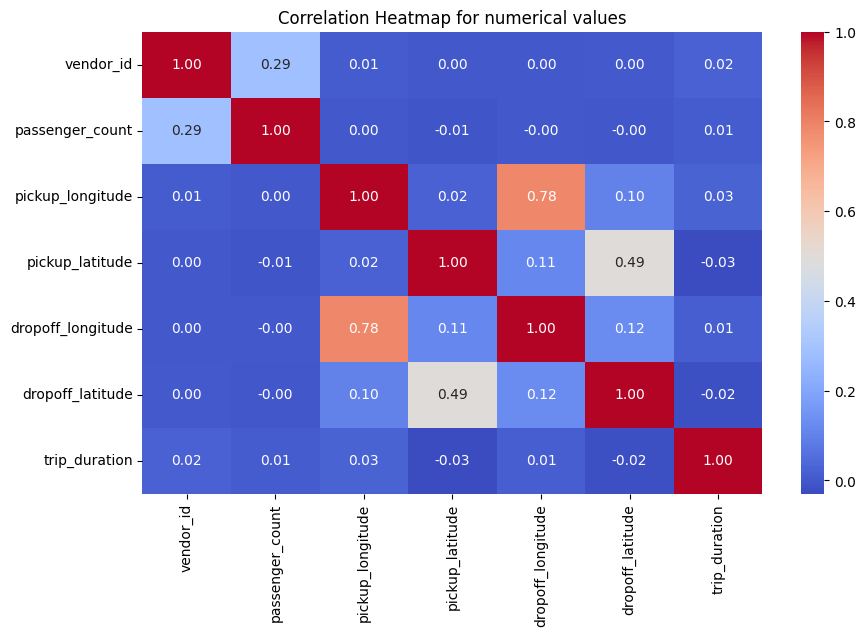

In [5]:
numeric_cols = df_train.select_dtypes(include=[np.number]).columns

corr_matrix = df_train[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for numerical values')
plt.show()

Examples of Possible Outliers:

1. Trip Duration:

Trips with a duration equal to 0 or very close to zero (seconds/minutes).
Extremely long trip durations (e.g., trips lasting entire days).

2. Geographical Coordinates:

Coordinates located far away from NYC or completely inconsistent.
Cases where pickup and drop-off coordinates are identical, but the trip duration is unusually large.

3. Number of Passengers:

Anomalous passenger counts, such as:
Zero passengers (unrealistic for a valid trip).
More than 6–7 passengers, which is atypical for standard vehicles.

In [6]:
df_train['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

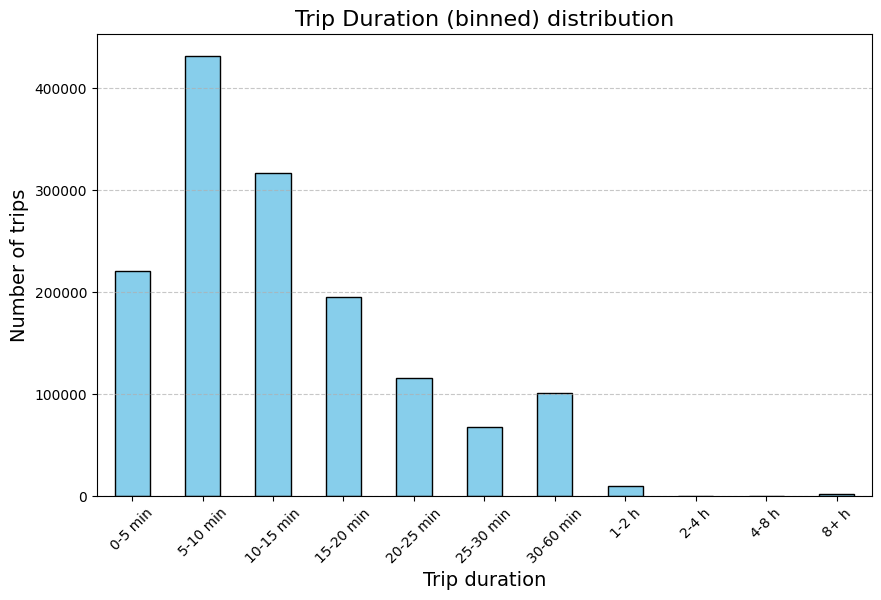

In [7]:
# Creare i bin per il trip_duration (in secondi)
bins = [0, 300, 600, 900, 1200, 1500, 1800, 3600, 7200, 14400, 28800, np.inf]  # Durata in secondi
labels = [
    "0-5 min", "5-10 min", "10-15 min","15-20 min", "20-25 min", "25-30 min", "30-60 min",
    "1-2 h", "2-4 h", "4-8 h", "8+ h"
]

# Creare una colonna con le categorie binned
df_train['trip_duration_binned'] = pd.cut(df_train['trip_duration'], bins=bins, labels=labels, right=False)

# Contare il numero di osservazioni per ciascun bin
bin_counts = df_train['trip_duration_binned'].value_counts(sort=False)

# Ordinare in base ai bin
bin_counts = bin_counts.sort_index()

# Visualizzare l'istogramma
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Aggiungere titolo e etichette
plt.title('Trip Duration (binned) distribution', fontsize=16)
plt.xlabel('Trip duration', fontsize=14)
plt.ylabel('Number of trips', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Using IQR (Interquartile Range) to Detect Trip Duration Anomalies:
Calculate the IQR:

Compute the IQR as the difference between the third quartile ($Q3$, 75th percentile) and the first quartile ($Q1$, 25th percentile):
IQR = Q3 − Q1

Define Outlier Thresholds:

Values below the lower threshold: Q1 − 2*IQR

Values above the upper threshold: Q3 + 2*IQR

Filter Outliers:

Values outside these thresholds are considered outliers.
Trips with durations below the lower limit or above the upper limit can be filtered out as anomalies.

In [9]:
Q1 = df_train['trip_duration'].quantile(0.25)  # 25° percentile
Q3 = df_train['trip_duration'].quantile(0.75)  # 75° percentile
IQR = Q3 - Q1  # Interquartile Range

lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

df = df_train[(df_train['trip_duration'] >= lower_bound) & (df_train['trip_duration'] <= upper_bound)]

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")
print(f"Number of rows after filtering: {len(df)}")

Lower bound: -959.0
Upper bound: 2431.0
Number of rows after filtering: 1411096


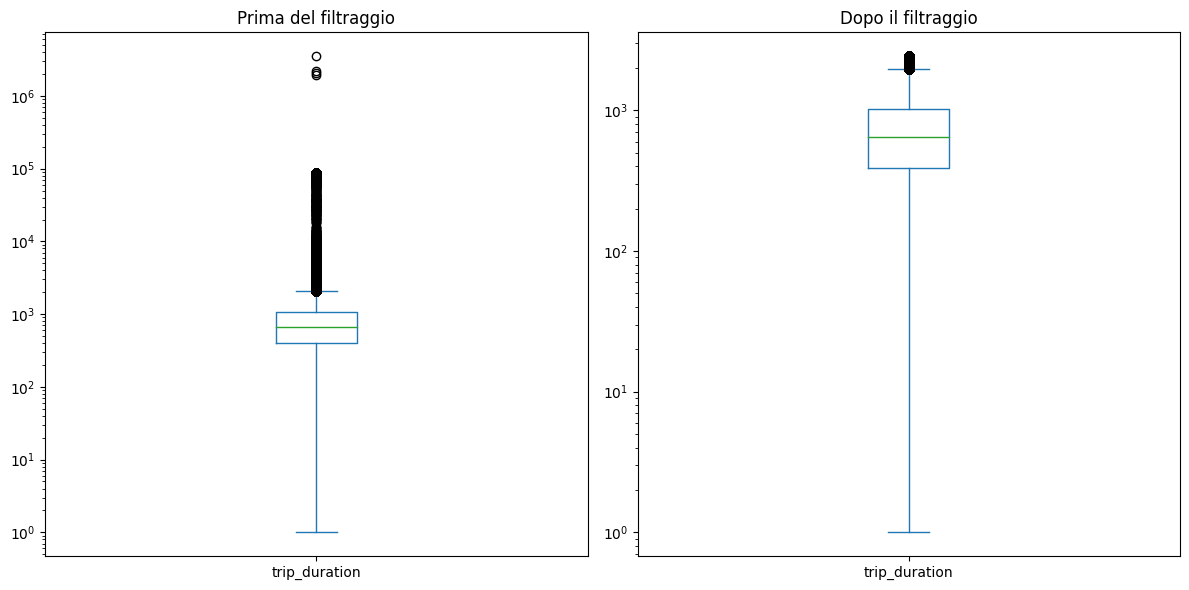

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df_train['trip_duration'].plot(kind='box', title='Prima del filtraggio')
plt.yscale('log')

plt.subplot(1, 2, 2)
df['trip_duration'].plot(kind='box', title='Dopo il filtraggio')
plt.yscale('log')

plt.tight_layout()
plt.show()

<ipython-input-13-37dedbcfe85f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)


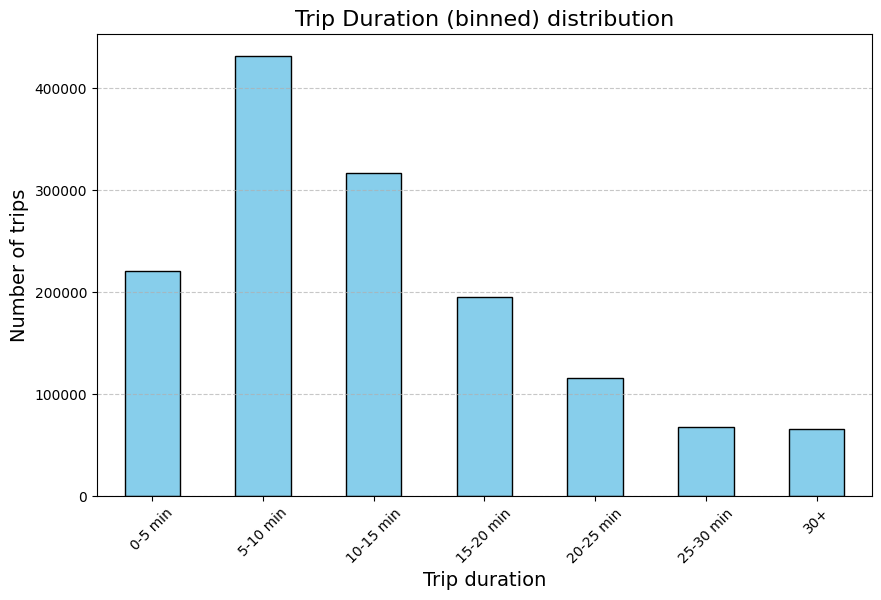

In [13]:
bins = [0, 300, 600, 900, 1200, 1500, 1800, np.inf]
labels = [
    "0-5 min", "5-10 min", "10-15 min","15-20 min", "20-25 min", "25-30 min", "30+"]
    

df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)

bin_counts = df['trip_duration_binned'].value_counts(sort=False)

bin_counts = bin_counts.sort_index()

plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Trip Duration (binned) distribution', fontsize=16)
plt.xlabel('Trip duration', fontsize=14)
plt.ylabel('Number of trips', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [14]:
print('-------------------------------------')
print(df_train['trip_duration'].describe())
print('-------------------------------------')
print(df['trip_duration'].describe())
print('-------------------------------------')

-------------------------------------
count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64
-------------------------------------
count    1.411096e+06
mean     7.603384e+02
std      4.896415e+02
min      1.000000e+00
25%      3.890000e+02
50%      6.430000e+02
75%      1.020000e+03
max      2.431000e+03
Name: trip_duration, dtype: float64
-------------------------------------


<ipython-input-15-c94c31b2bc04>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)


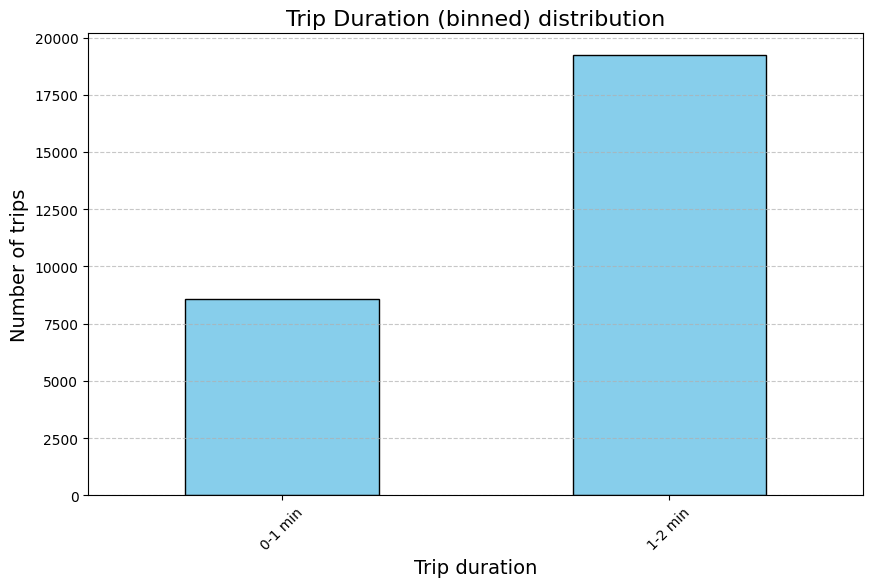

In [15]:
bins = [0, 60, 120] 
labels = [
    "0-1 min", "1-2 min"]
    
df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)

bin_counts = df['trip_duration_binned'].value_counts(sort=False)

bin_counts = bin_counts.sort_index()

plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Trip Duration (binned) distribution', fontsize=16)
plt.xlabel('Trip duration', fontsize=14)
plt.ylabel('Number of trips', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we remove the istances that are classificated like "outliers".
NB: For lower_bound we choise like treshold 2 minute (120 seconds).

In [16]:
df = df_train[(df_train['trip_duration'] <= upper_bound) & (df_train['trip_duration'] >= 120)]
len(df)

1383279

<ipython-input-17-3ff15741f6de>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)


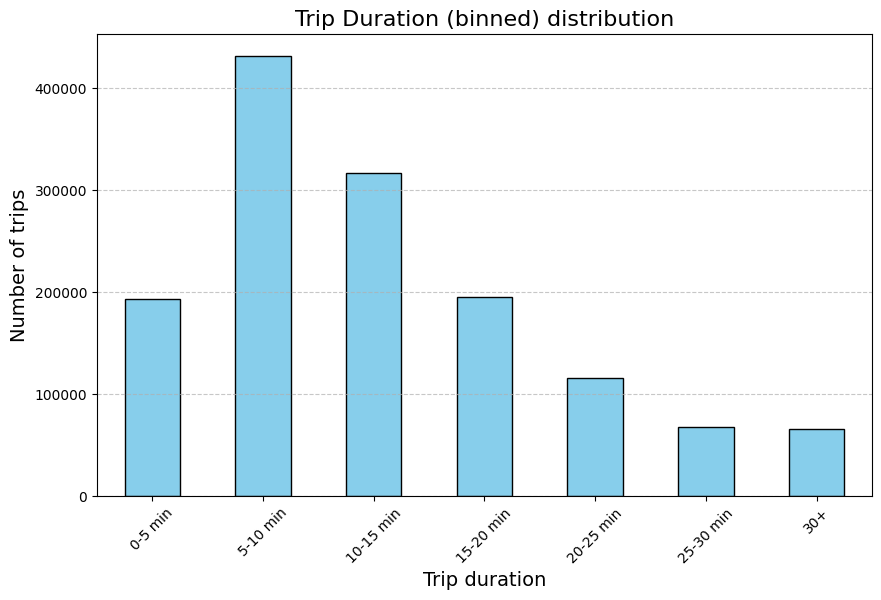

In [17]:
bins = [0, 300, 600, 900, 1200, 1500, 1800, np.inf]  # Durata in secondi
labels = [
    "0-5 min", "5-10 min", "10-15 min","15-20 min", "20-25 min", "25-30 min", "30+"]    

df['trip_duration_binned'] = pd.cut(df['trip_duration'], bins=bins, labels=labels, right=False)

bin_counts = df['trip_duration_binned'].value_counts(sort=False)

bin_counts = bin_counts.sort_index()

plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Trip Duration (binned) distribution', fontsize=16)
plt.xlabel('Trip duration', fontsize=14)
plt.ylabel('Number of trips', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_binned
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,5-10 min
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,10-15 min
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,30+


## Feature Engineering (do NOT run this part)

Remove the id-variable and "dropoff_date_time" for training set (couse we don't have the features in test set)

In [57]:
'''df = df[['vendor_id','pickup_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration']]

df_test = df_test[['vendor_id','pickup_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag']]'''

"df = df[['vendor_id','pickup_datetime',\n       'passenger_count', 'pickup_longitude', 'pickup_latitude',\n       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',\n       'trip_duration']]\n\ndf_test = df_test[['vendor_id','pickup_datetime',\n       'passenger_count', 'pickup_longitude', 'pickup_latitude',\n       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag']]"

Now we want to see if we can do something about the "spatial" variables:

['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']

This code defines two functions that calculate geographic metrics based on latitude and longitude: haversine distance and bearing (displacement angle).

1. Haversine Formula (Function: haversine)
Purpose: Computes the great-circle distance between two points on the Earth’s surface, accounting for the Earth's curvature.

2. Bearing (Displacement Angle) (Function: calculate_bearing)
Purpose: Calculates the direction (bearing) from one point to another on the Earth’s surface.

In [58]:
'''# Real geographic distance (with haversine formula)
R = 6371  # Raggio medio della Terra in km
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Displacement angle (Bearing)
def calculate_bearing(lat1, lon1, lat2, lon2):
    # Convertire le coordinate da gradi a radianti
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Calcolo del bearing
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    initial_bearing = np.arctan2(x, y)
    # Convertire il bearing da radianti a gradi
    initial_bearing = np.degrees(initial_bearing)
    # Portare l'angolo nel range [0, 360)
    bearing = (initial_bearing + 360) % 360
    return bearing'''

"# Real geographic distance (with haversine formula)\nR = 6371  # Raggio medio della Terra in km\ndef haversine(lat1, lon1, lat2, lon2):\n    # Convertire le coordinate da gradi a radianti\n    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])\n    dlat = lat2 - lat1\n    dlon = lon2 - lon1\n    # Formula dell'haversine\n    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2\n    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))\n    distance = R * c\n    return distance\n\n# Displacement angle (Bearing)\ndef calculate_bearing(lat1, lon1, lat2, lon2):\n    # Convertire le coordinate da gradi a radianti\n    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])\n    # Calcolo del bearing\n    dlon = lon2 - lon1\n    x = np.sin(dlon) * np.cos(lat2)\n    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)\n    initial_bearing = np.arctan2(x, y)\n    # Convertire il bearing da radianti a gradi\n    initial_bearing

**Displacement angle** tells us if the trip is oriented **north**(near 0°), **east*(90°), **south**(180°) or **west**(270°).


In [59]:
'''df['distance_km'] = df.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],
                          row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df['bearing'] = df.apply(
    lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'],
                                  row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df.head(3)'''

"df['distance_km'] = df.apply(\n    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],\n                          row['dropoff_latitude'], row['dropoff_longitude']), axis=1)\ndf['bearing'] = df.apply(\n    lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'],\n                                  row['dropoff_latitude'], row['dropoff_longitude']), axis=1)\ndf.head(3)"

In [60]:
'''# Do same for test_set:
df_test['distance_km'] = df_test.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],
                          row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

df_test['bearing'] = df_test.apply(
    lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'],
                                  row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df_test.head(3)'''

"# Do same for test_set:\ndf_test['distance_km'] = df_test.apply(\n    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],\n                          row['dropoff_latitude'], row['dropoff_longitude']), axis=1)\n\ndf_test['bearing'] = df_test.apply(\n    lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'],\n                                  row['dropoff_latitude'], row['dropoff_longitude']), axis=1)\ndf_test.head(3)"

This code assigns the NYC boroughs (e.g., Manhattan, Brooklyn) to the pickup and dropoff points in both the training and test datasets using spatial data.

In [61]:
'''# Carica i confini dei borough (GeoJSON o Shapefile)
boroughs = gpd.read_file("/kaggle/input/borough-boundaries-geojson/Borough Boundaries.geojson")  # Sostituisci con il file corretto
boroughs = boroughs[['boro_name', 'geometry']]  # Tieni solo il nome del distretto e i poligoni

# Crea punti geografici per pickup e dropoff nel training set
df['pickup_point'] = df.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
df['dropoff_point'] = df.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Crea punti geografici per pickup e dropoff nel test set
df_test['pickup_point'] = df_test.apply(lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1)
df_test['dropoff_point'] = df_test.apply(lambda row: Point(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Converti i DataFrame in GeoDataFrame
gdf_pickup = gpd.GeoDataFrame(df, geometry='pickup_point', crs=boroughs.crs)
gdf_dropoff = gpd.GeoDataFrame(df, geometry='dropoff_point', crs=boroughs.crs)

gdf_pickup_test = gpd.GeoDataFrame(df_test, geometry='pickup_point', crs=boroughs.crs)
gdf_dropoff_test = gpd.GeoDataFrame(df_test, geometry='dropoff_point', crs=boroughs.crs)

# Funzione per assegnare il borough o "not_known"
def assign_borough(point, boroughs):
    for _, row in boroughs.iterrows():
        if point.within(row['geometry']):
            return row['boro_name']
    return 'not_known'

# Assegna il distretto per pickup e dropoff nel training set
df['pickup_borough'] = gdf_pickup['pickup_point'].apply(lambda x: assign_borough(x, boroughs))
df['dropoff_borough'] = gdf_dropoff['dropoff_point'].apply(lambda x: assign_borough(x, boroughs))

# Assegna il distretto per pickup e dropoff nel test set
df_test['pickup_borough'] = gdf_pickup_test['pickup_point'].apply(lambda x: assign_borough(x, boroughs))
df_test['dropoff_borough'] = gdf_dropoff_test['dropoff_point'].apply(lambda x: assign_borough(x, boroughs))

# Rimuovi le colonne temporanee nel training e test set
df = df.drop(columns=['pickup_point', 'dropoff_point'])
df_test = df_test.drop(columns=['pickup_point', 'dropoff_point'])'''

'# Carica i confini dei borough (GeoJSON o Shapefile)\nboroughs = gpd.read_file("/kaggle/input/borough-boundaries-geojson/Borough Boundaries.geojson")  # Sostituisci con il file corretto\nboroughs = boroughs[[\'boro_name\', \'geometry\']]  # Tieni solo il nome del distretto e i poligoni\n\n# Crea punti geografici per pickup e dropoff nel training set\ndf[\'pickup_point\'] = df.apply(lambda row: Point(row[\'pickup_longitude\'], row[\'pickup_latitude\']), axis=1)\ndf[\'dropoff_point\'] = df.apply(lambda row: Point(row[\'dropoff_longitude\'], row[\'dropoff_latitude\']), axis=1)\n\n# Crea punti geografici per pickup e dropoff nel test set\ndf_test[\'pickup_point\'] = df_test.apply(lambda row: Point(row[\'pickup_longitude\'], row[\'pickup_latitude\']), axis=1)\ndf_test[\'dropoff_point\'] = df_test.apply(lambda row: Point(row[\'dropoff_longitude\'], row[\'dropoff_latitude\']), axis=1)\n\n# Converti i DataFrame in GeoDataFrame\ngdf_pickup = gpd.GeoDataFrame(df, geometry=\'pickup_point\', crs=

Now work on the time features (like data "pickup_datetime")

We want obtain different features to explain month, day and hour. We are going to remove the year cause it's only 2016.

Evaluation of the Variables that we want to create:
1. Minutes (minute):
Reasoning:
The minute variable represents the exact minute within an hour (e.g., 17:24 → 24 minutes).
There is no strong logical relationship between the exact minute and the trip duration, as traffic or trip patterns are unlikely to depend on specific minutes, so we are going to remove the minute variable.

2. Hour of the Day (hour):
Reasoning:
The hour variable could impact trip duration due to its relationship with traffic conditions (e.g., longer trips during rush hours like 8-10 AM or 5-7 PM).

3. Day (day):
Reasoning:
The day variable might affect trip duration if the dataset spans a longer period and shows day-specific patterns (e.g., weekends could have different traffic levels than weekdays).

4. Month (month):
Reasoning:
The month variable may be useful for identifying seasonal patterns (e.g., less traffic in summer or during holidays).

5. Month/Day :
Reasoning:
The month/day variable represents a specific calendar date (e.g., "01/15" for January 15th).
It could be useful for identifying specific trends or patterns on certain dates, such as:
Holidays: Traffic might be lighter or heavier on holidays (e.g., Christmas, New Year).
Weekday vs. Weekend: Certain dates inherently fall into weekdays or weekends, affecting traffic patterns.

6. Weekday :
Reasoning:
The weekday variable represents the day of the week (e.g., 0 for Monday, 6 for Sunday).
This variable is highly relevant for trip duration because:
Weekdays vs. Weekends: Traffic patterns differ significantly; weekdays often experience rush hours, while weekends generally have lighter traffic.
Specific Days: Some weekdays, like Fridays, might show distinct patterns due to increased evening activity.

In [62]:
'''# Per il training set
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour      # Ore del giorno
df['day'] = df['pickup_datetime'].dt.day        # Giorno
df['month'] = df['pickup_datetime'].dt.month    # Mese
df['year'] = df['pickup_datetime'].dt.year      # Anno

# Aggiungi giorno della settimana (weekday)
df['weekday'] = df['pickup_datetime'].dt.weekday

# Aggiungi combinazione mese/giorno
df['month_day'] = df['month'].astype(str) + '/' + df['day'].astype(str)

# Per il test set
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['hour'] = df_test['pickup_datetime'].dt.hour      # Ore del giorno
df_test['day'] = df_test['pickup_datetime'].dt.day        # Giorno
df_test['month'] = df_test['pickup_datetime'].dt.month    # Mese
df_test['year'] = df_test['pickup_datetime'].dt.year      # Anno

# Aggiungi giorno della settimana (weekday)
df_test['weekday'] = df_test['pickup_datetime'].dt.weekday

# Aggiungi combinazione mese/giorno
df_test['month_day'] = df_test['month'].astype(str) + '/' + df_test['day'].astype(str)

# Rimuovi l'anno (non utile perché è costante)
df = df.drop(columns=['year'])
df_test = df_test.drop(columns=['year'])
df = df.drop(columns=['pickup_datetime'], errors='ignore')
df_test = df_test.drop(columns=['pickup_datetime'], errors='ignore')'''

"# Per il training set\ndf['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])\ndf['hour'] = df['pickup_datetime'].dt.hour      # Ore del giorno\ndf['day'] = df['pickup_datetime'].dt.day        # Giorno\ndf['month'] = df['pickup_datetime'].dt.month    # Mese\ndf['year'] = df['pickup_datetime'].dt.year      # Anno\n\n# Aggiungi giorno della settimana (weekday)\ndf['weekday'] = df['pickup_datetime'].dt.weekday\n\n# Aggiungi combinazione mese/giorno\ndf['month_day'] = df['month'].astype(str) + '/' + df['day'].astype(str)\n\n# Per il test set\ndf_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])\ndf_test['hour'] = df_test['pickup_datetime'].dt.hour      # Ore del giorno\ndf_test['day'] = df_test['pickup_datetime'].dt.day        # Giorno\ndf_test['month'] = df_test['pickup_datetime'].dt.month    # Mese\ndf_test['year'] = df_test['pickup_datetime'].dt.year      # Anno\n\n# Aggiungi giorno della settimana (weekday)\ndf_test['weekday'] = df_test['pickup_datetime'].dt.

In [63]:
'''print(df.shape)
print(df_test.shape)
print(df.columns)
print(df_test.columns)
df.head(3)'''

'print(df.shape)\nprint(df_test.shape)\nprint(df.columns)\nprint(df_test.columns)\ndf.head(3)'

We are going to load the final dataset with all the data engineering already processed.

In [4]:
df = pd.read_csv('/kaggle/input/dataset/Per_trip/df_train.csv')
df_test = pd.read_csv('/kaggle/input/dataset/Per_trip/df_test.csv')

df.head(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_km,bearing,pickup_borough,dropoff_borough,hour,day,month,weekday,month_day
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,99.970196,Manhattan,Manhattan,17,14,3,0,3/14
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,242.846232,Manhattan,Manhattan,0,12,6,6,6/12
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,200.319835,Manhattan,Manhattan,11,19,1,1,1/19


## Data Preparation

Encoding for categorical variables with too much levels.

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['month_day'] = le.fit_transform(df['month_day'])
df_test['month_day'] = le.transform(df_test['month_day'])

In [6]:
df['passenger_count'] = df['passenger_count'].astype('int8')
df['hour'] = df['hour'].astype('int8')
df['day'] = df['day'].astype('int8')
df['month'] = df['month'].astype('int8')
df['vendor_id'] = df['vendor_id'].astype('int8')
df['weekday'] = df['weekday'].astype('int8')
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1}).astype(int)

df_test['passenger_count'] = df_test['passenger_count'].astype('int8')
df_test['hour'] = df_test['hour'].astype('int8')
df_test['day'] = df_test['day'].astype('int8')
df_test['month'] = df_test['month'].astype('int8')
df_test['vendor_id'] = df_test['vendor_id'].astype('int8')
df_test['weekday'] = df_test['weekday'].astype('int8')
df_test['store_and_fwd_flag'] = df_test['store_and_fwd_flag'].map({'N': 0, 'Y': 1}).astype(int)

One hot encoding for weekday and 

In [7]:
# Assumi che la colonna 'weekday' esista e contenga valori interi (0 = Lunedì, 6 = Domenica)

# One-Hot Encoding con pd.get_dummies
weekday_encoded = pd.get_dummies(df['weekday'], prefix='weekday')

# Aggiungi le nuove colonne al DataFrame
df = pd.concat([df, weekday_encoded], axis=1)

# One-Hot Encoding con pd.get_dummies
weekday_encoded = pd.get_dummies(df_test['weekday'], prefix='weekday')

# Aggiungi le nuove colonne al DataFrame
df_test = pd.concat([df_test, weekday_encoded], axis=1)

df = df.drop(columns=['weekday'], errors='ignore')
df_test = df_test.drop(columns=['weekday'], errors='ignore')
# Stampa il risultato
print(df.head())

   vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.982155        40.767937   
1          1                1        -73.980415        40.738564   
2          2                1        -73.979027        40.763939   
3          2                1        -74.010040        40.719971   
4          2                1        -73.973053        40.793209   

   dropoff_longitude  dropoff_latitude  store_and_fwd_flag  trip_duration  \
0         -73.964630         40.765602                   0            455   
1         -73.999481         40.731152                   0            663   
2         -74.005333         40.710087                   0           2124   
3         -74.012268         40.706718                   0            429   
4         -73.972923         40.782520                   0            435   

   distance_km     bearing  ... day month  month_day  weekday_0  weekday_1  \
0     1.498521   99.970196  ...  14     3         

In [8]:
df.pickup_borough.unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'not_known', 'Bronx',
       'Staten Island'], dtype=object)

In [9]:
all_data = pd.concat([df, df_test], axis=0)

encoded_pickup = pd.get_dummies(all_data['pickup_borough'], prefix='pickup_borough', drop_first=False)
encoded_dropoff = pd.get_dummies(all_data['dropoff_borough'], prefix='dropoff_borough', drop_first=False)

df = pd.concat([df, encoded_pickup.iloc[:len(df)]], axis=1)
df_test = pd.concat([df_test, encoded_pickup.iloc[len(df):]], axis=1)

df = pd.concat([df, encoded_dropoff.iloc[:len(df)]], axis=1)
df_test = pd.concat([df_test, encoded_dropoff.iloc[len(df):]], axis=1)

In [10]:
df = df.drop(columns=['pickup_borough'], errors='ignore')
df_test = df_test.drop(columns=['pickup_borough'], errors='ignore')
df = df.drop(columns=['dropoff_borough'], errors='ignore')
df_test = df_test.drop(columns=['dropoff_borough'], errors='ignore')

In [11]:
print(df.dtypes)

vendor_id                           int8
passenger_count                     int8
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
store_and_fwd_flag                 int64
trip_duration                      int64
distance_km                      float64
bearing                          float64
hour                                int8
day                                 int8
month                               int8
month_day                          int64
weekday_0                           bool
weekday_1                           bool
weekday_2                           bool
weekday_3                           bool
weekday_4                           bool
weekday_5                           bool
weekday_6                           bool
pickup_borough_Bronx                bool
pickup_borough_Brooklyn             bool
pickup_borough_Manhattan            bool
pickup_borough_Q

Split in train and validation. Preparing data for training deep NN.

In [12]:
X = df.drop(columns=['trip_duration'])
y = df['trip_duration']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Seconda divisione: 10% validation, 10% test dal temporaneo (50%-50% dello 0.2 totale)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verifica le proporzioni
print(f"Training set: {len(X_train)/len(X):.2%}")
print(f"Validation set: {len(X_val)/len(X):.2%}")
print(f"Test set: {len(X_test)/len(X):.2%}")

Training set: 80.00%
Validation set: 10.00%
Test set: 10.00%


Neural networks perform better when input features are on a similar scale, ensuring faster and more stable convergence during training. So we are going to scale them.

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Train the model

## First Model

In [14]:
def rmsle(y_true, y_pred):
    y_true = tf.maximum(y_true, 0)  # Per sicurezza, evita valori negativi
    y_pred = tf.maximum(y_pred, 0)
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))

This neural network is designed for regression, with progressively smaller dense layers to capture complex patterns while reducing computational cost. The ReLU activation is used for non-linearity, and the linear activation in the output layer is suitable for continuous target values.

We use Adam optimizer with a learning rate of 0.001 for efficient weight updates. To enhance training stability:

ReduceLROnPlateau dynamically lowers the learning rate if validation loss plateaus, promoting better convergence.
EarlyStopping prevents overfitting by halting training when no significant improvement in validation loss is observed, restoring the best model weights for final evaluation.

In [15]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output per la regressione
])
model.compile(optimizer=Adam(learning_rate=0.001), loss=rmsle, metrics=['mae'])
model.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitora la perdita sul validation set
    factor=0.5,          # Riduce il learning rate del 50%
    patience=3,          # Numero di epoche senza miglioramenti significativi
    min_delta=1e-4,      # Miglioramento minimo richiesto (ad esempio 1e-4  ->  0.0001)
    min_lr=1e-6,         # Limite minimo per il learning rate
    verbose=1            # Mostra messaggi quando il learning rate viene ridotto
)
early_stopping= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,713 (202.00 KB)

 Trainable params: 51,713 (202.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Formula for MAE

The formula to calculate the MAE is as follows:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

Where:
- $n$ is the total number of observations.
- $y_i$ is the actual target value for observation \(i\).
- $\hat{y}_i$ is the predicted value by the model for observation \(i\).
- $|y_i - \hat{y}_i|$ is the absolute error for observation \(i\).

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[reduce_lr, early_stopping],  # callback
    verbose=1
)

Epoch 1/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.6904 - mae: 330.9392 - val_loss: 0.3868 - val_mae: 214.2681 - learning_rate: 0.0010
Epoch 2/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3911 - mae: 212.3800 - val_loss: 0.3750 - val_mae: 199.8756 - learning_rate: 0.0010
Epoch 3/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3733 - mae: 198.7216 - val_loss: 0.3666 - val_mae: 194.0307 - learning_rate: 0.0010
Epoch 4/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3635 - mae: 192.9365 - val_loss: 0.3836 - val_mae: 201.3692 - learning_rate: 0.0010
Epoch 5/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3581 - mae: 189.8988 - val_loss: 0.3616 - val_mae: 190.4148 - learning_rate: 0.0010
Epoch 6/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3545 - mae: 188.1121 - val_loss: 0.3519 - val_mae: 186.2395 - learning_rate: 0.0010
Epoch 7/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3531 - mae: 187.6178 - val_loss: 0.3482 -

In [17]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.3338, Validation MAE: 178.7190


Validation MAE: It is the Mean Absolute Error, meaning the model has, on average, an error of 178.71 seconds (approximately 3 minutes) per prediction.
If the target variable (trip_duration) typically has values in the range of a few minutes (e.g., between 2 and 15 minutes), an error of 3 minutes could be considered high.
On the other hand, if the trips are significantly longer (e.g., 30–60 minutes), an error of 3 minutes might be acceptable. In our case we are in the middle, so we know for sure that we can improve.

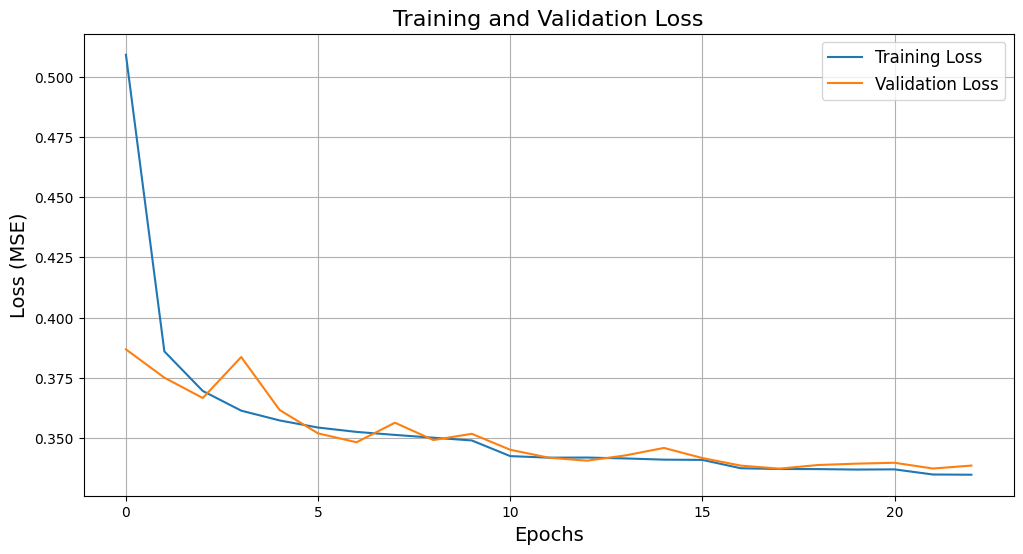

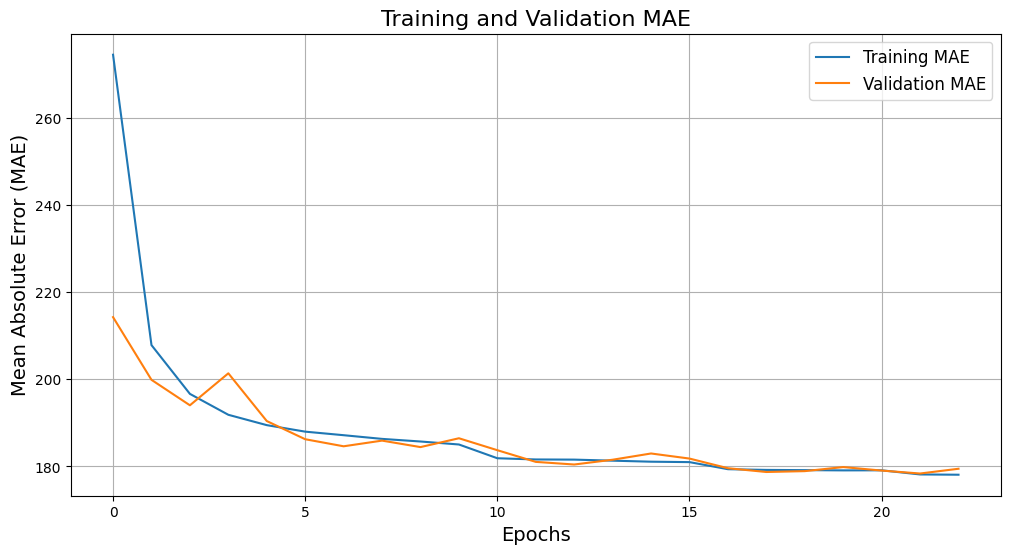

In [18]:
# Recupera i dati dal training
history_dict = history.history

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# MAE
train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

# Crea il grafico della loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Crea il grafico del MAE
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

The model shows consistent learning, with training and validation loss decreasing steadily and closely aligning, indicating good generalization and no overfitting. Both MSE and MAE stabilize after the initial epochs, suggesting the model converges well and could potentially stop training earlier around epoch 15. This is a solid baseline performance.

## Second Model

The main difference in this model compared to the previous one is the use of the tanh activation function in the first dense layer instead of ReLU.

tanh scales outputs between -1 and 1, allowing the model to learn negative and positive feature contributions, which can be useful for certain data distributions.
The remaining architecture, optimizer, learning rate schedule, and early stopping parameters remain unchanged.

In [19]:
model2 = Sequential([
    Dense(256, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output per la regressione
])
model2.compile(optimizer=Adam(learning_rate=0.001), loss=rmsle, metrics=['mae'])
model2.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitora la perdita sul validation set
    factor=0.5,          # Riduce il learning rate del 50%
    patience=3,          # Numero di epoche senza miglioramenti significativi
    min_delta=1e-4,      # Miglioramento minimo richiesto (ad esempio 1e-4  ->  0.0001)
    min_lr=1e-6,         # Limite minimo per il learning rate
    verbose=1            # Mostra messaggi quando il learning rate viene ridotto
)
early_stopping= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,713 (202.00 KB)

 Trainable params: 51,713 (202.00 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[reduce_lr, early_stopping],  # callback
    verbose=1
)

Epoch 1/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.6975 - mae: 339.9567 - val_loss: 0.4460 - val_mae: 240.7329 - learning_rate: 0.0010
Epoch 2/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.3945 - mae: 214.6845 - val_loss: 0.3770 - val_mae: 204.2997 - learning_rate: 0.0010
Epoch 3/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3787 - mae: 204.3613 - val_loss: 0.3661 - val_mae: 197.2362 - learning_rate: 0.0010
Epoch 4/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3669 - mae: 197.0715 - val_loss: 0.3589 - val_mae: 191.0557 - learning_rate: 0.0010
Epoch 5/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3614 - mae: 192.7677 - val_loss: 0.3568 - val_mae: 190.9962 - learning_rate: 0.0010
Epoch 6/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3570 - mae: 190.5056 - val_loss: 0.3519 - val_mae: 187.8096 - learning_rate: 0.0010
Epoch 7/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3545 - mae: 188.4169 - val_loss: 0.3530 -

Really small improvement with the tanh.

In [21]:
val_loss, val_mae = model2.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.3325, Validation MAE: 178.1342


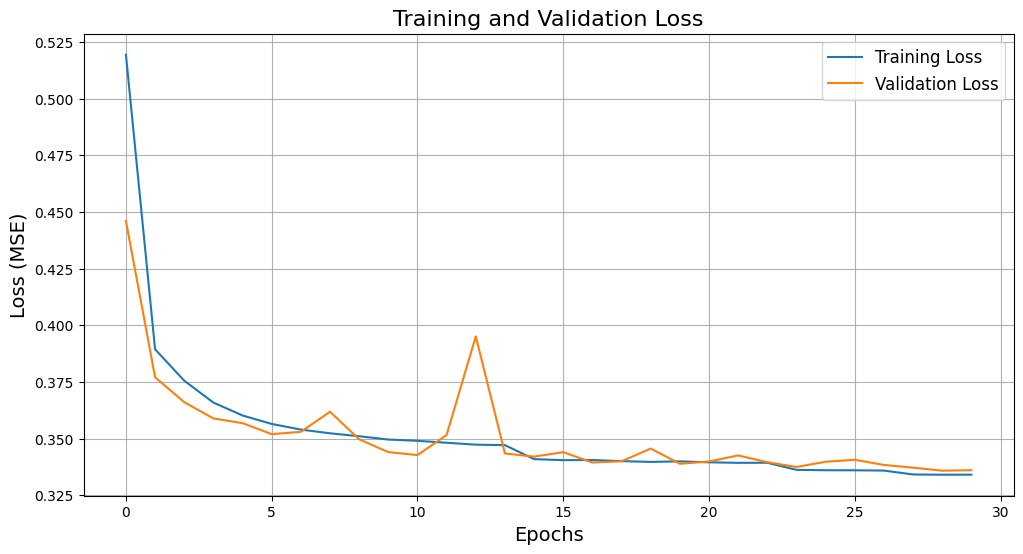

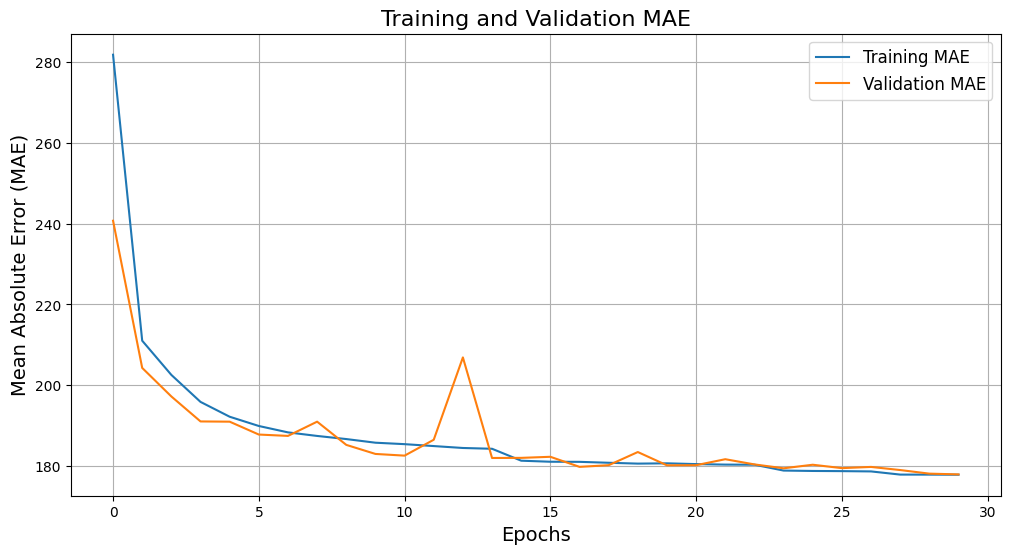

In [22]:
# Recupera i dati dal training
history_dict = history2.history

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# MAE
train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

# Crea il grafico della loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Crea il grafico del MAE
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

The model generally converges well, with training and validation loss closely aligned. The spike in validation loss and MAE around epoch 10 suggests a temporary instability, likely caused by overfitting to noisy patterns or fluctuations in the validation set. Afterward, the model recovers and stabilizes, indicating good generalization overall.

## Third Model

Increased Model Complexity:
Larger Layers: The first layer has 1024 neurons, followed by progressively smaller layers (512, 256, etc.), which significantly increases the model's capacity to learn complex patterns.
There are 7 layers in total (compared to 4 or 5 in previous models), which allows the model to capture more intricate relationships in the data.
Same Activation Setup as model2:
The first layer still uses tanh, which helps learn both negative and positive contributions.
The remaining layers use ReLU, maintaining non-linearity and avoiding vanishing gradients.

In [23]:
model3 = Sequential([
    Dense(1024, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Output per la regressione
])
model3.compile(optimizer=Adam(learning_rate=0.001), loss=rmsle, metrics=['mae'])
model3.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitora la perdita sul validation set
    factor=0.5,          # Riduce il learning rate del 50%
    patience=3,          # Numero di epoche senza miglioramenti significativi
    min_delta=1e-4,      # Miglioramento minimo richiesto (ad esempio 1e-4  ->  0.0001)
    min_lr=1e-6,         # Limite minimo per il learning rate
    verbose=1            # Mostra messaggi quando il learning rate viene ridotto
)
early_stopping= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 1024)                │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 796,929 (3.04 MB)

 Trainable params: 796,929 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[reduce_lr, early_stopping],  # callback
    verbose=1
)

Epoch 1/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.5641 - mae: 293.4816 - val_loss: 0.3713 - val_mae: 196.9843 - learning_rate: 0.0010
Epoch 2/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3781 - mae: 200.2167 - val_loss: 0.3664 - val_mae: 194.1349 - learning_rate: 0.0010
Epoch 3/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.3645 - mae: 192.8620 - val_loss: 0.3558 - val_mae: 190.2261 - learning_rate: 0.0010
Epoch 4/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.3609 - mae: 190.6832 - val_loss: 0.3551 - val_mae: 187.0636 - learning_rate: 0.0010
Epoch 5/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.3563 - mae: 188.1917 - val_loss: 0.3516 - val_mae: 185.9196 - learning_rate: 0.0010
Epoch 6/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.3548 - mae: 187.2354 - val_loss: 0.3523 - val_mae: 185.4883 - learning_rate: 0.0010
Epoch 7/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.3524 - mae: 186.4701 - val_loss: 0.3621 -

In [25]:
val_loss, val_mae = model3.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.3309, Validation MAE: 176.4509


From 178 to 176, good improvement.

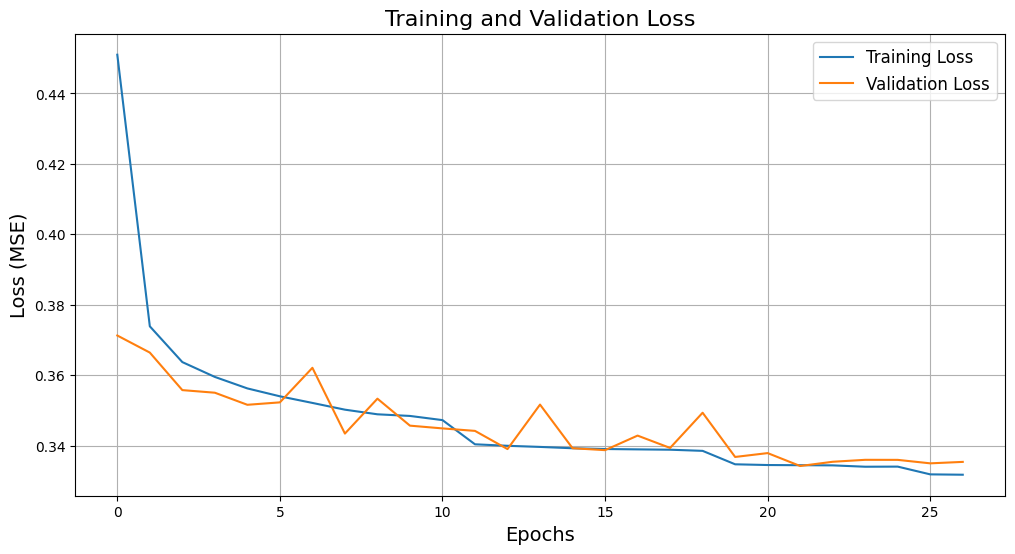

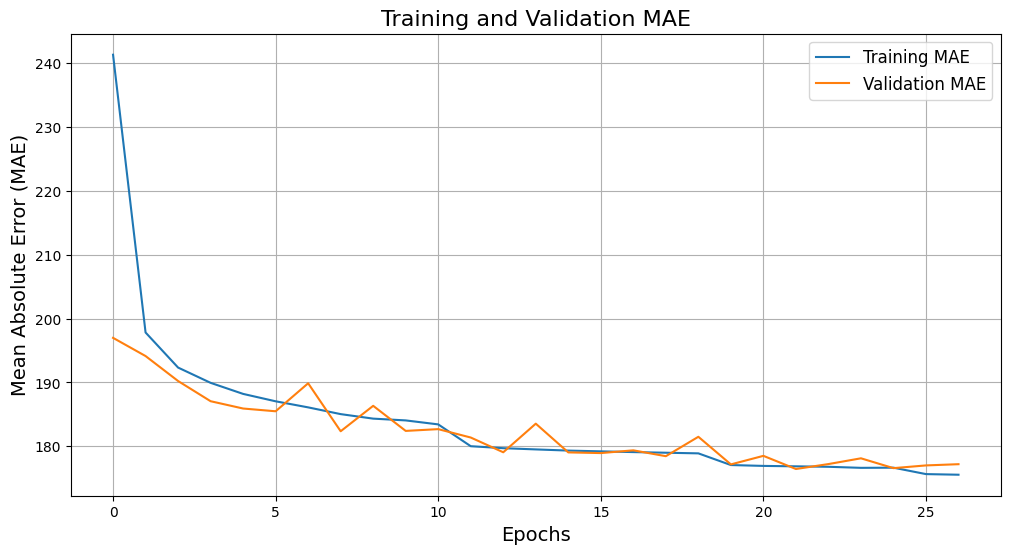

In [26]:
# Recupera i dati dal training
history_dict = history3.history

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# MAE
train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

# Crea il grafico della loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Crea il grafico del MAE
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

The absence of a validation loss spike, as seen in the second model, suggests better training stability and less overfitting.
The convergence is slightly slower than the first model but more controlled, with training and validation metrics closely aligned, indicating strong generalization and less noise in the validation predictions.

## Fourth Model

This fourth model introduces significant complexity and scale compared to the previous ones. Here's what changes:

1. Larger Model Capacity:
Bigger Layers:
The first layer has 2048 neurons, followed by layers of 1024, 512, 256, etc. This is a substantial increase in the number of parameters compared to previous models.
Multiple repetitions of similarly sized layers (e.g., two layers with 1024 and 512 neurons) increase the model's ability to capture very complex patterns in the data.

2. Deeper Architecture:

With 9 layers, this is the deepest architecture yet, making it more capable of modeling intricate relationships but also significantly increasing computational cost.

3. Smaller Learning Rate:

The learning rate has been reduced from 0.001 to 0.0001, which helps the model converge more gradually and stably, especially with such a large number of parameters.
This adjustment prevents large weight updates, reducing the risk of overshooting the optimal solution, particularly for deep and large networks.

In [27]:
model4 = Sequential([
    Dense(2048, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Output per la regressione
])
model4.compile(optimizer=Adam(learning_rate=0.0001), loss=rmsle, metrics=['mae'])
model4.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=3,          
    min_delta=1e-4,      
    min_lr=1e-6,         
    verbose=1           
)
early_stopping= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 2048)                │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,241,153 (16.18 MB)

 Trainable params: 4,241,153 (16.18 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history4 = model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[reduce_lr, early_stopping],  # callback
    verbose=1
)

Epoch 1/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 0.6965 - mae: 331.9298 - val_loss: 0.3819 - val_mae: 204.4519 - learning_rate: 1.0000e-04
Epoch 2/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.3827 - mae: 202.9228 - val_loss: 0.3638 - val_mae: 192.6004 - learning_rate: 1.0000e-04
Epoch 3/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.3649 - mae: 193.1460 - val_loss: 0.3542 - val_mae: 187.4344 - learning_rate: 1.0000e-04
Epoch 4/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.3580 - mae: 189.4979 - val_loss: 0.3509 - val_mae: 185.0435 - learning_rate: 1.0000e-04
Epoch 5/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.3550 - mae: 187.7600 - val_loss: 0.3546 - val_mae: 186.9434 - learning_rate: 1.0000e-04
Epoch 6/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.3512 - mae: 185.8075 - val_loss: 0.3464 - val_mae: 182.9562 - learning_rate: 1.0000e-04
Epoch 7/30
8646/8646 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.3491 - mae: 184.4

In [29]:
val_loss, val_mae = model4.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.3299, Validation MAE: 175.6956


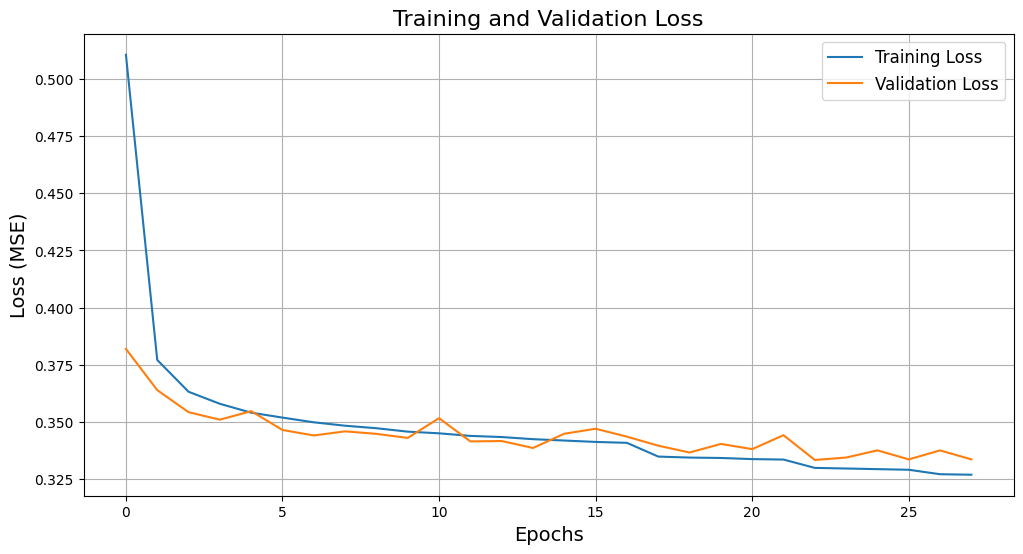

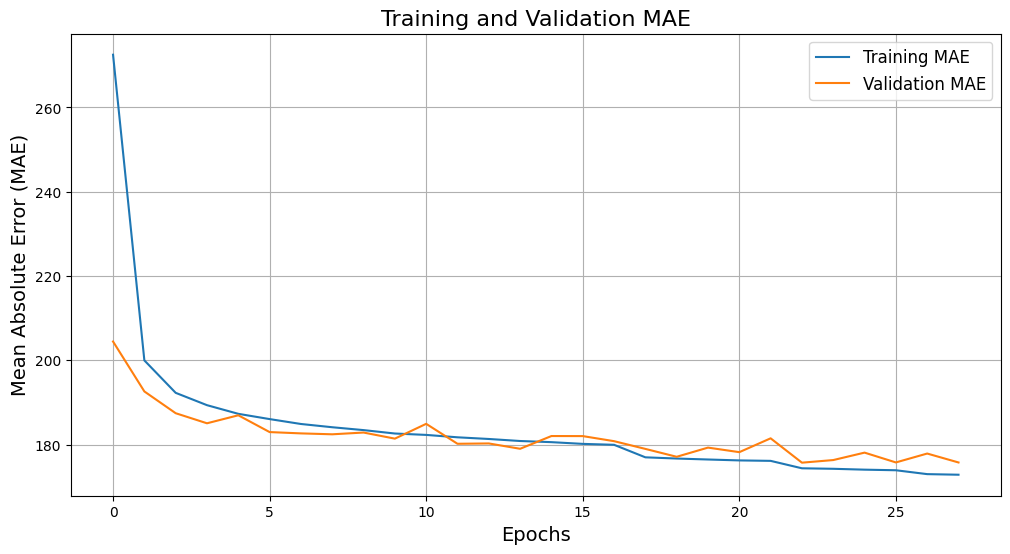

In [30]:
# Recupera i dati dal training
history_dict = history4.history

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# MAE
train_mae = history_dict['mae']
val_mae = history_dict['val_mae']

# Crea il grafico della loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Crea il grafico del MAE
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In this code, we use LIME (Local Interpretable Model-agnostic Explanations) to explain the predictions of model4 for a specific instance in the dataset. We create a LimeTabularExplainer using the training data and feature names, ensuring it's compatible with regression tasks. Then, we select a single instance from the training data and pass it to the explainer, along with a prediction function adapted for LIME. The explainer generates an interpretable explanation for the model's prediction, showing the most influential features. Finally, the explanation is displayed in a notebook-friendly format.

In [41]:
feature_names= ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'distance_km', 'bearing', 'hour', 'day', 'month',
       'month_day', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'pickup_borough_Bronx',
       'pickup_borough_Brooklyn', 'pickup_borough_Manhattan',
       'pickup_borough_Queens', 'pickup_borough_Staten Island',
       'pickup_borough_not_known', 'dropoff_borough_Bronx',
       'dropoff_borough_Brooklyn', 'dropoff_borough_Manhattan',
       'dropoff_borough_Queens', 'dropoff_borough_Staten Island',
       'dropoff_borough_not_known']

In [42]:
print(len(feature_names))
print(X_train.shape[1])

32
32


In [43]:
from lime.lime_tabular import LimeTabularExplainer

instance_index = 0  # Numero dell'istanza
instance = X_train[instance_index].reshape(1, -1)  

def predict_fn(data):
    return model4.predict(data).flatten()  # Deve restituire un array 1D per LIME

# Crea un LimeTabularExplainer
explainer = LimeTabularExplainer(
    training_data=X_train,         # Dati di addestramento (array NumPy)
    mode='regression',             # Modalità regressione
    feature_names=feature_names,   # Nomi delle feature
    verbose=True,                  # Mostra dettagli
    random_state=42                # Per risultati ripetibili
)

# Genera una spiegazione per l'istanza
explanation = explainer.explain_instance(
    data_row=instance.flatten(),   # I dati da spiegare
    predict_fn=predict_fn,         # La funzione predittiva
    num_features=20                # Numero massimo di feature da mostrare nella spiegazione
)

# Visualizza la spiegazione
explanation.show_in_notebook(show_table=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Intercept 5583.606138825162
Prediction_local [678.4894833]
Right: 454.56412


This LIME explanation visualizes the contributions of various features to the model's prediction for a single instance. Features on the positive side increase the predicted value (e.g., weekday_1), while features on the negative side decrease it (e.g., pickup_borough_not_known). The bar lengths indicate the magnitude of their influence. The prediction value aligns with the model's output, showing how individual features collectively affect the result. Features with zero contribution have no impact on this specific instance's prediction.

In the next code, we use LIME to explain the model's predictions for a set of instances and compute the overall importance of features based on these local explanations. For each selected instance in instances_indices, the code generates a LIME explanation highlighting the top 5 most influential features. These features and their importances are saved in a dictionary for each instance.

The feature importances are then aggregated across all instances, weighted by their absolute contributions. Finally, the features are ranked by their overall importance, providing a global view of which features are most influential for the model across the analyzed instances.

In [55]:
import random
from collections import Counter, defaultdict

instances_index = []
for i in range(0,1000):
    r = random.randint(0,1106622)    #numero di istanze del trainig set
    instances_index.append(r)

In [59]:
# Funzione di previsione compatibile con LIME
def predict_fn(data):
    return model4.predict(data).flatten()  # Deve restituire un array 1D per LIME

# Creazione del LimeTabularExplainer
explainer = LimeTabularExplainer(
    training_data=X_train,         # Dati di addestramento (array NumPy)
    mode='regression',             # Modalità regressione
    feature_names=feature_names,   # Nomi delle feature (lista)
    verbose=False,                 # Non mostra dettagli
    random_state=42                # Per risultati ripetibili
)

# Dizionario per salvare le feature importanti per ogni istanza
feature_importances = {}

# Itera sulle istanze selezionate
for instance_index in instances_index:  # Usa il nome corretto della lista
    instance = X_train[instance_index].reshape(1, -1)  # Accesso diretto tramite NumPy
    
    # Genera una spiegazione per l'istanza
    explanation = explainer.explain_instance(
        data_row=instance.flatten(),   # Dati da spiegare
        predict_fn=predict_fn,         # Funzione predittiva
        num_features=5                 # Numero massimo di feature nella spiegazione
    )

    # Salva le 5 feature più importanti con le loro importanze
    local_importances = explanation.as_list()
    feature_importances[instance_index] = {
        feature.split(' ')[0]: abs(importance) for feature, importance in local_importances
    }

# Calcolo delle importanze ponderate
weighted_importances = defaultdict(float)
for instance_dict in feature_importances.values():
    for feature, importance in instance_dict.items():
        weighted_importances[feature] += importance

# Normalizza le importanze ponderate
num_instances = len(instances_index)  # Usa la lunghezza della lista corretta
for feature in weighted_importances:
    weighted_importances[feature] /= (num_instances * 5)  # Normalizzazione per istanze e feature

# Ordina le feature per importanza
sorted_features = sorted(weighted_importances.items(), key=lambda x: x[1], reverse=True)

# Estrai i nomi delle feature e le loro importanze
features, weighted_counts = zip(*sorted_features)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━

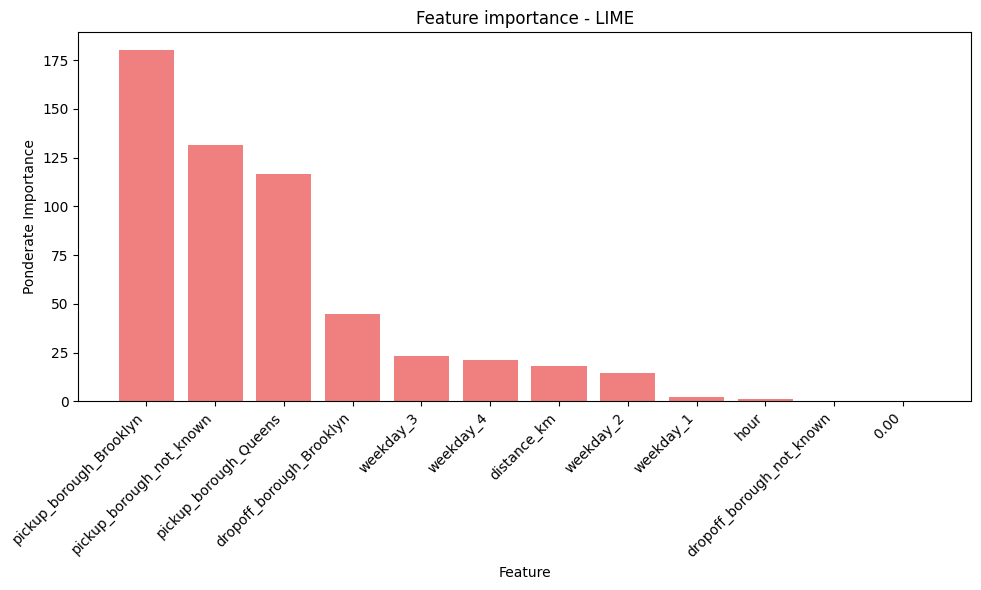

In [74]:
# Crea un istogramma ponderato
plt.figure(figsize=(10, 6))
plt.bar(features, weighted_counts, color='lightcoral')
plt.xlabel('Feature')
plt.ylabel('Ponderate Importance')
plt.title('Feature importance - LIME')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The chart shows the weighted importance of features based on LIME explanations. The most influential features are related to the pickup and dropoff locations, particularly pickup_borough_Brooklyn, pickup_borough_not_known, and pickup_borough_Queens, indicating that the model heavily relies on the geographic location to make predictions.

Time-related features like weekday_3 and weekday_4 also contribute significantly, suggesting that the day of the week plays a role in influencing the predictions, likely due to varying traffic patterns. Less important features like hour and distance_km have minimal impact, which may imply that the model is capturing the majority of variance through location-based features. This suggests the model prioritizes spatial over temporal or other contextual factors for its predictions.

## Confronto tra le varie reti

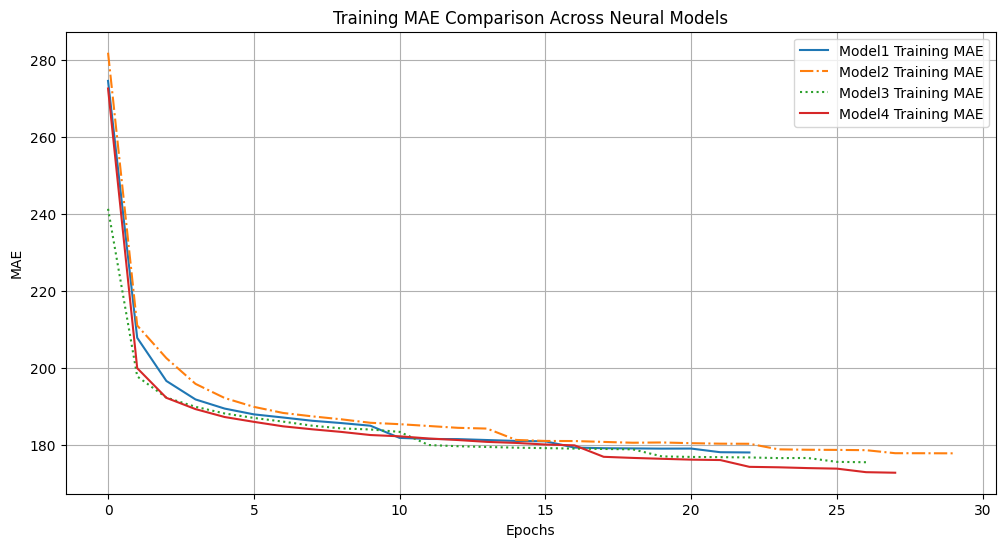

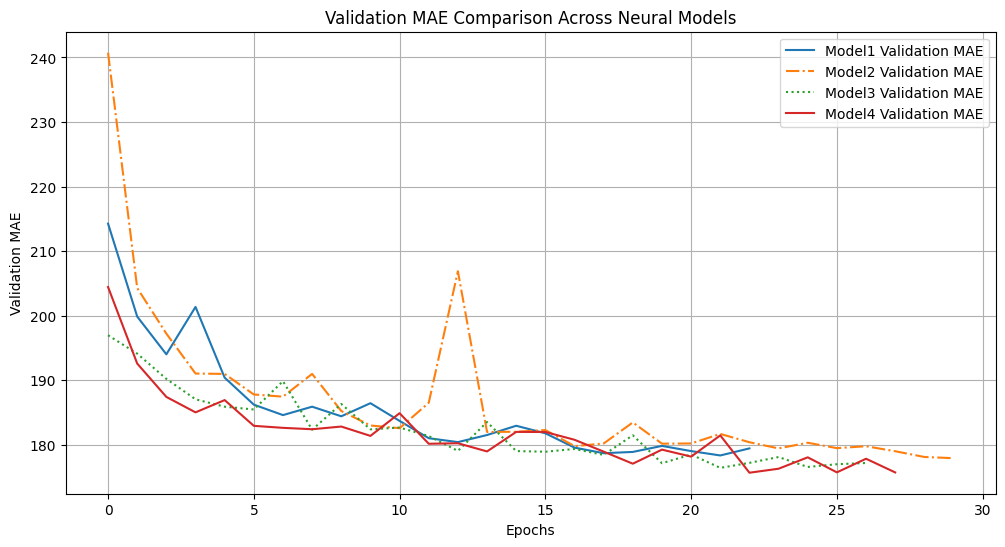

In [57]:
# Recupera i dati dal training
history_model = history.history
history_model2 = history2.history
history_model3 = history3.history
history_model4 = history4.history

# Plotta i risultati del training
plt.figure(figsize=(12, 6))
plt.plot(history_model['mae'], label='Model1 Training MAE', linestyle='-')
plt.plot(history_model2['mae'], label='Model2 Training MAE', linestyle='-.')
plt.plot(history_model3['mae'], label='Model3 Training MAE', linestyle=':')
plt.plot(history_model4['mae'], label='Model4 Training MAE', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training MAE Comparison Across Neural Models')
plt.legend()
plt.grid(True)
plt.show()

# Plotta i risultati della validazione
plt.figure(figsize=(12, 6))
plt.plot(history_model['val_mae'], label='Model1 Validation MAE', linestyle='-')
plt.plot(history_model2['val_mae'], label='Model2 Validation MAE', linestyle='-.')
plt.plot(history_model3['val_mae'], label='Model3 Validation MAE', linestyle=':')
plt.plot(history_model4['val_mae'], label='Model4 Validation MAE', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Validation MAE Comparison Across Neural Models')
plt.legend()
plt.grid(True)
plt.show()

The training MAE curves show that all models converge similarly, with a steady decline in error, stabilizing after about 10 epochs. Model 4 demonstrates slightly better performance in terms of lower training MAE, likely due to its higher capacity.

For validation MAE, Model 4 consistently outperforms the others, showing the lowest error across epochs, indicating better generalization. Model 2 exhibits some instability with a noticeable spike, likely due to overfitting or sensitivity to noise. Overall, Model 4 provides the best balance between learning capacity and stability, while the other models exhibit slightly higher validation MAE, suggesting less effective generalization.

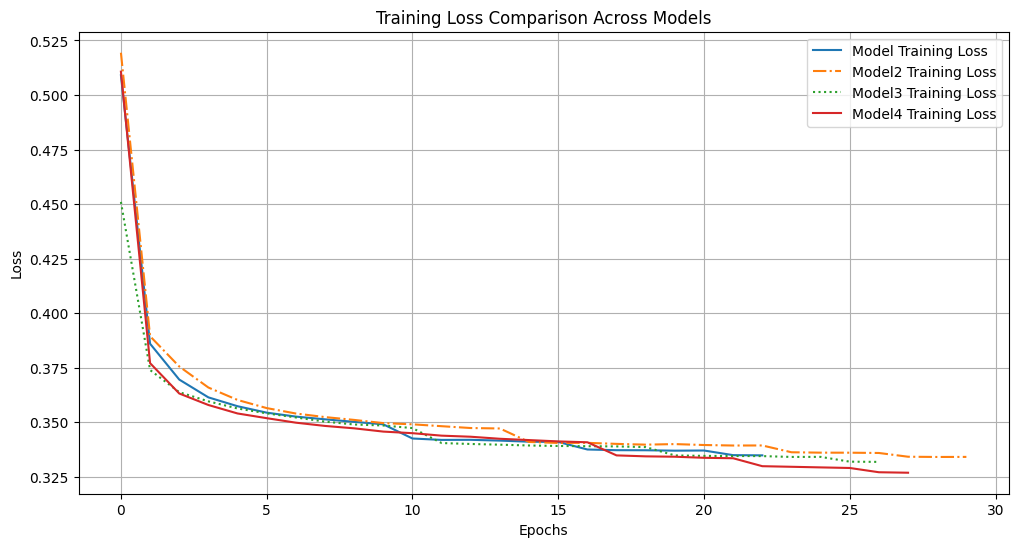

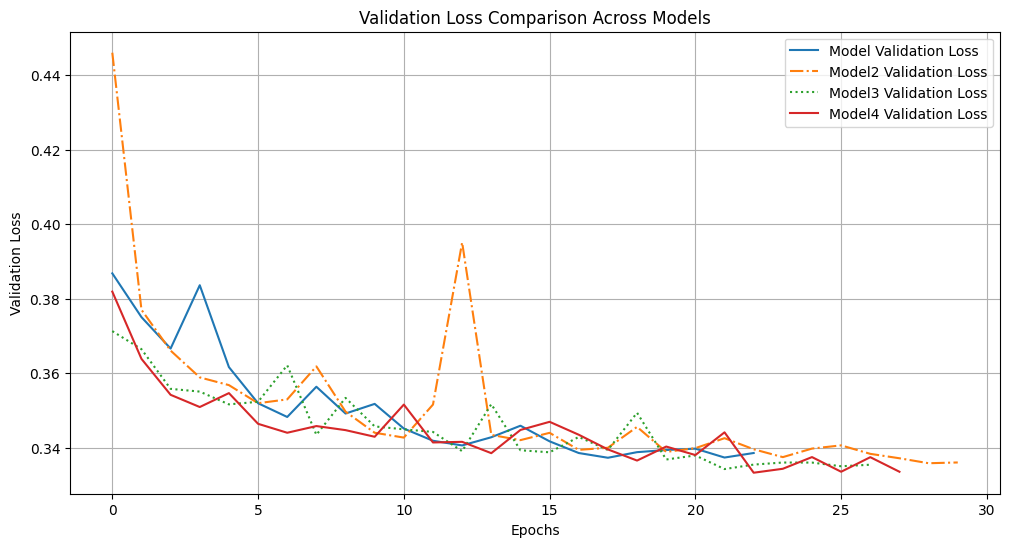

In [58]:
# Plotta i risultati del training
plt.figure(figsize=(12, 6))
plt.plot(history_model['loss'], label='Model Training Loss', linestyle='-')
plt.plot(history_model2['loss'], label='Model2 Training Loss', linestyle='-.')
plt.plot(history_model3['loss'], label='Model3 Training Loss', linestyle=':')
plt.plot(history_model4['loss'], label='Model4 Training Loss', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison Across Models')
plt.legend()
plt.grid(True)
plt.show()

# Plotta i risultati della validazione
plt.figure(figsize=(12, 6))
plt.plot(history_model['val_loss'], label='Model Validation Loss', linestyle='-')
plt.plot(history_model2['val_loss'], label='Model2 Validation Loss', linestyle='-.')
plt.plot(history_model3['val_loss'], label='Model3 Validation Loss', linestyle=':')
plt.plot(history_model4['val_loss'], label='Model4 Validation Loss', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison Across Models')
plt.legend()
plt.grid(True)
plt.show()

The training loss curves for all models show similar trends, with rapid convergence in the initial epochs and stabilization after about 10 epochs. Model 4 slightly outperforms the others, achieving the lowest training loss, likely due to its greater capacity.

For validation loss, Model 4 again exhibits the most stable and lowest values, indicating strong generalization. Model 2 shows instability with a pronounced spike, reflecting sensitivity to noise or overfitting. Model 1 and Model 3 demonstrate more consistent performance but do not reach the low loss values of Model 4. Overall, Model 4 provides the best balance between training and validation performance, while Model 2 struggles with stability.

Evaluation on the test set

In [52]:
# Funzione RMSLE (custom)
def rmsle(y_true, y_pred):
    y_true = np.maximum(y_true, 0)  # Per sicurezza, evita valori negativi
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Dizionario per salvare i risultati
results = {
    'Model': [],
    'MAE': [],
    'RMSLE': []
}

# Funzione per valutare un modello
def evaluate_model(model, model_name, X_test, y_test):
    predictions = model.predict(X_test).flatten()  # Ottieni le predizioni
    mae = mean_absolute_error(y_test, predictions)
    rmsle_score = rmsle(y_test, predictions)
    results['Model'].append(model_name)
    results['MAE'].append(mae)
    results['RMSLE'].append(rmsle_score)

# Valutazione dei 4 modelli
evaluate_model(model, "Model_1", X_test, y_test)
evaluate_model(model2, "Model 2", X_test, y_test)
evaluate_model(model3, "Model 3", X_test, y_test)
evaluate_model(model4, "Model 4", X_test, y_test)

# Convertire i risultati in un DataFrame
results_df = pd.DataFrame(results)

4323/4323 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4323/4323 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


Confronto delle performance:
     Model          MAE     RMSLE
0  Model_1  7665.389338  6.112454
1  Model 2  1275.230807  1.301812
2  Model 3   436.088492  0.898779
3  Model 4   337.122376  0.594191


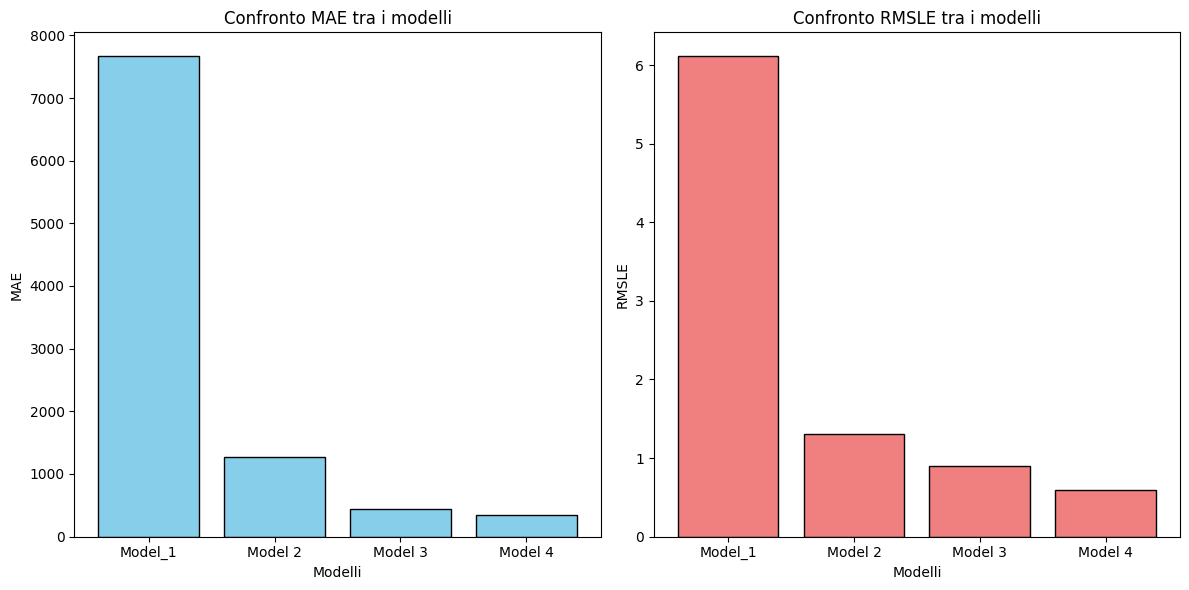

In [53]:
# Mostrare i risultati
print("Confronto delle performance:")
print(results_df)

# Grafico comparativo
plt.figure(figsize=(12, 6))

# Grafico MAE
plt.subplot(1, 2, 1)
plt.bar(results_df['Model'], results_df['MAE'], color='skyblue', edgecolor='black')
plt.title('Confronto MAE tra i modelli')
plt.xlabel('Modelli')
plt.ylabel('MAE')

# Grafico RMSLE
plt.subplot(1, 2, 2)
plt.bar(results_df['Model'], results_df['RMSLE'], color='lightcoral', edgecolor='black')
plt.title('Confronto RMSLE tra i modelli')
plt.xlabel('Modelli')
plt.ylabel('RMSLE')

plt.tight_layout()
plt.show()

The performance comparison on the new test set highlights the significant differences between the models. Model 1 performs the worst by a large margin, with extremely high MAE and RMSLE values, indicating poor generalization and significant errors in predictions. Model 2 improves drastically with lower errors but still struggles compared to the more refined models.

Model 3 shows a significant improvement, achieving a much lower MAE and RMSLE, indicating better performance and generalization. However, Model 4 outperforms all others, achieving the lowest MAE and RMSLE values. This demonstrates that Model 4 is the most effective and accurate for the given test set, with both minimal error and strong generalization.The performance comparison on the new test set highlights the significant differences between the models. Model 1 performs the worst by a large margin, with extremely high MAE and RMSLE values, indicating poor generalization and significant errors in predictions. Model 2 improves drastically with lower errors but still struggles compared to the more refined models.

Model 3 shows a significant improvement, achieving a much lower MAE and RMSLE, indicating better performance and generalization. However, Model 4 outperforms all others, achieving the lowest MAE and RMSLE values. This demonstrates that Model 4 is the most effective and accurate for the given test set, with both minimal error and strong generalization.

## XGboost

We decided to switch from neural networks to XGBoost because it often performs better with structured/tabular data. XGBoost is more interpretable, handles missing values natively, and requires less fine-tuning for small-to-medium-sized datasets compared to neural networks, which can overfit or struggle with such data.

In [61]:
model5 = XGBRegressor(
    n_estimators=500,       # Numero di alberi più alto
    max_depth=6,            # Profondità massima (ottimizzata)
    learning_rate=0.05,     # Tasso di apprendimento ridotto
    subsample=0.8,          # Percentuale di campioni
    colsample_bytree=0.8,   # Percentuale di feature
    min_child_weight=5,     # Aumenta il valore per regolarizzazione
    gamma=0.1,              # Regolarizzazione per split
    random_state=42
)

In [62]:
# Allena il modello
model5.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)],  # Valida su validation set
          eval_metric="mae",         # Metriche per il validation set
          early_stopping_rounds=50,  # Interrompi se non migliora per 10 round
          verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [63]:
def rmsle(y_true, y_pred):
    # Conversione a float
    y_true = np.maximum(np.array(y_true, dtype=np.float64), 0)  # Evita valori negativi
    y_pred = np.maximum(np.array(y_pred, dtype=np.float64), 0)
    # RMSLE
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

In [64]:
# Predici sul validation set
y_pred = model5.predict(X_val)

# Calcola metriche di valutazione
mae = mean_absolute_error(y_val, y_pred)
rmsle = rmsle(y_val, y_pred)

print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSLE: {rmsle:.4f}")

Validation MAE: 159.9072
Validation RMSLE: 0.3105


The Validation MAE of 159.9072 and Validation RMSLE of 0.3105 indicate that this XGBoost model outperforms the previous neural network models.
This significant improvement suggests that XGBoost is better suited for this structured/tabular dataset, likely due to its ability to handle feature importance, interaction effects, and irregular distributions more effectively. 

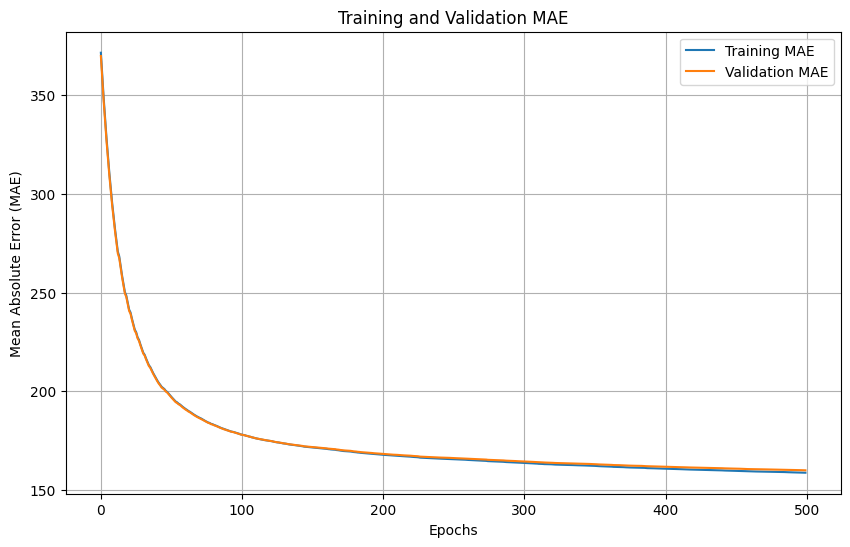

In [65]:
# Ottieni le metriche dal modello
results5 = model5.evals_result()

# Plotta le loss
plt.figure(figsize=(10, 6))
plt.plot(results5['validation_0']['mae'], label='Training MAE')
plt.plot(results5['validation_1']['mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

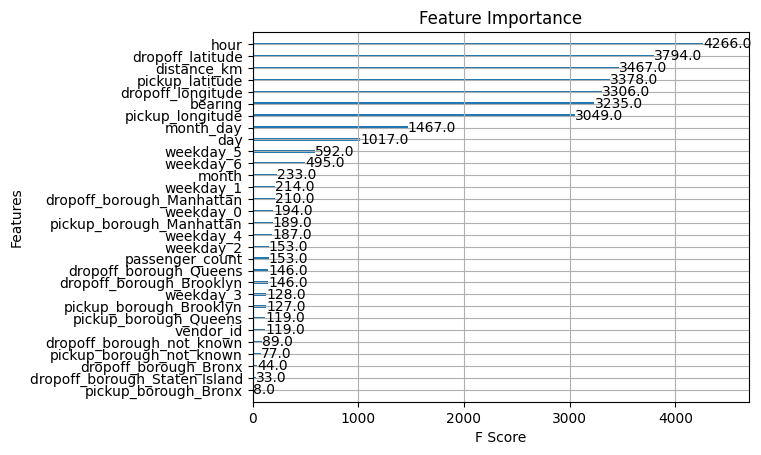

In [66]:
model5.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(10, 8))
plot_importance(model5, max_num_features=30, importance_type="weight", xlabel="F Score")
plt.title("Feature Importance")
plt.show()

This feature importance plot for the XGBoost model highlights the most significant contributors to its predictions. Temporal features like hour dominate, suggesting that the time of day is the strongest predictor, likely reflecting traffic patterns. Spatial features like dropoff_latitude, distance_km, and pickup_latitude also have high importance, indicating that geographic information is critical for the model.

## Final model

This configuration for model6 with XGBoost aims to increase its ability to capture complex patterns while incorporating stronger regularization to prevent overfitting.

- n_estimators=2000: A higher number of trees allows the model to learn more patterns but requires a lower learning rate to ensure stability.
- max_depth=8: Deeper trees can capture more complex interactions between features, increasing model capacity.
- learning_rate=0.01: A lower learning rate ensures that updates to the model are small and gradual, preventing overfitting despite the high number of estimators.
- subsample=0.7 and colsample_bytree=0.7: Using only 70% of the samples and features for each tree reduces overfitting by introducing randomness, making the model more robust.
- min_child_weight=10: Higher values enforce stricter splitting criteria, leading to simpler trees and preventing the model from fitting noise.

In [67]:
model6 = XGBRegressor(
    n_estimators=2000,       # Più alberi con learning rate più basso
    max_depth=8,             # Alberi più profondi
    learning_rate=0.01,      # Tasso di apprendimento ridotto
    subsample=0.7,           # Usa solo il 70% dei campioni
    colsample_bytree=0.7,    # Usa solo il 70% delle feature
    min_child_weight=10,     # Peso minimo dei figli aumentato
    gamma=0.2,               # Penalizzazione per split
    reg_alpha=0.1,           # Regolarizzazione L1
    reg_lambda=1.0,          # Regolarizzazione L2
    random_state=42
)

In [68]:
model6.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)],  # Valida su validation set
          eval_metric="mae",         # Metriche per il validation set
          early_stopping_rounds=30,  # Interrompi se non migliora per 30 round
          verbose=True)

[0]	validation_0-mae:381.76716	validation_1-mae:380.04309


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:379.10249	validation_1-mae:377.39168
[2]	validation_0-mae:376.48685	validation_1-mae:374.78927
[3]	validation_0-mae:373.88790	validation_1-mae:372.20454
[4]	validation_0-mae:371.36588	validation_1-mae:369.69636
[5]	validation_0-mae:368.84813	validation_1-mae:367.19138
[6]	validation_0-mae:366.39759	validation_1-mae:364.75536
[7]	validation_0-mae:365.19726	validation_1-mae:363.56681
[8]	validation_0-mae:362.77851	validation_1-mae:361.16597
[9]	validation_0-mae:360.50561	validation_1-mae:358.90943
[10]	validation_0-mae:358.14101	validation_1-mae:356.55623
[11]	validation_0-mae:355.80876	validation_1-mae:354.23677
[12]	validation_0-mae:353.47072	validation_1-mae:351.91357
[13]	validation_0-mae:352.42648	validation_1-mae:350.88137
[14]	validation_0-mae:350.25710	validation_1-mae:348.72850
[15]	validation_0-mae:348.00215	validation_1-mae:346.48604
[16]	validation_0-mae:345.77135	validation_1-mae:344.26975
[17]	validation_0-mae:343.57286	validation_1-mae:342.08196
[18]	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [69]:
def rmsle(y_true, y_pred):
    # Conversione a float
    y_true = np.maximum(np.array(y_true, dtype=np.float64), 0)  # Evita valori negativi
    y_pred = np.maximum(np.array(y_pred, dtype=np.float64), 0)
    # RMSLE
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

In [70]:
# Predici sul validation set
y_pred = model6.predict(X_val)

# Calcola metriche di valutazione
mae = mean_absolute_error(y_val, y_pred)
rmsle = rmsle(y_val, y_pred)

print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSLE: {rmsle:.4f}")

Validation MAE: 153.3156
Validation RMSLE: 0.2989


With a Validation MAE of 153.3156 and Validation RMSLE of 0.2989, this XGBoost configuration achieves a slight improvement over the previous model (MAE: 159.9072, RMSLE: 0.3105). The lower MAE indicates more accurate predictions, while the reduced RMSLE suggests better handling of proportional errors for trips with smaller durations.

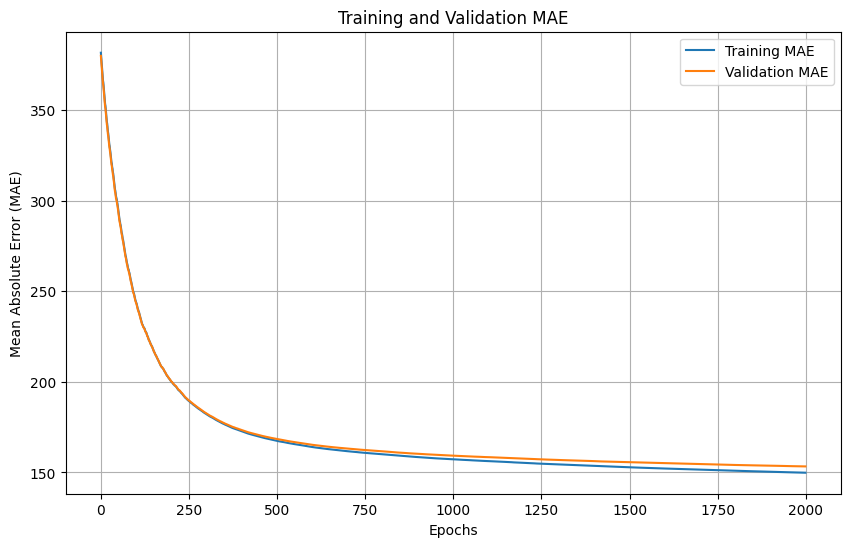

In [71]:
# Ottieni le metriche dal modello
results6 = model6.evals_result()

# Plotta le loss
plt.figure(figsize=(10, 6))
plt.plot(results6['validation_0']['mae'], label='Training MAE')
plt.plot(results6['validation_1']['mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

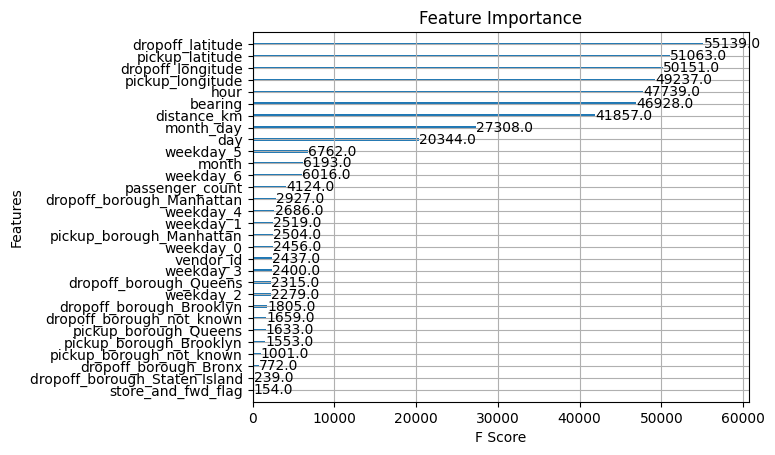

In [72]:
model6.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(10, 8))
plot_importance(model6, max_num_features=30, importance_type="weight", xlabel="F Score")
plt.title("Feature Importance")
plt.show()

This updated feature importance plot reveals that spatial features, such as dropoff_latitude, pickup_latitude, and dropoff_longitude, remain the most critical predictors, highlighting the model's reliance on precise geographic data. Temporal features like hour and bearing also play a significant role, suggesting their importance in capturing time-based patterns such as traffic or directionality effects.

## XGBOOST without scaling and with label encoding instead of one hot

In [75]:
df = pd.read_csv('/kaggle/input/dataset/Per_trip/df_train.csv')
df_test = pd.read_csv('/kaggle/input/dataset/Per_trip/df_test.csv')

df.head(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_km,bearing,pickup_borough,dropoff_borough,hour,day,month,weekday,month_day
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,99.970196,Manhattan,Manhattan,17,14,3,0,3/14
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,242.846232,Manhattan,Manhattan,0,12,6,6,6/12
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,200.319835,Manhattan,Manhattan,11,19,1,1,1/19


In [76]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['month_day'] = le.fit_transform(df['month_day'])
df_test['month_day'] = le.transform(df_test['month_day'])
df['pickup_borough'] = le.fit_transform(df['pickup_borough'])
df_test['pickup_borough'] = le.transform(df_test['pickup_borough'])
df['dropoff_borough'] = le.fit_transform(df['dropoff_borough'])
df_test['dropoff_borough'] = le.transform(df_test['dropoff_borough'])

In [77]:
df['passenger_count'] = df['passenger_count'].astype('int8')
df['hour'] = df['hour'].astype('int8')
df['day'] = df['day'].astype('int8')
df['month'] = df['month'].astype('int8')
df['vendor_id'] = df['vendor_id'].astype('int8')
df['weekday'] = df['weekday'].astype('int8')
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1}).astype(int)
df['pickup_borough'] = df['pickup_borough'].astype('int8')
df['dropoff_borough'] = df['dropoff_borough'].astype('int8')

df_test['passenger_count'] = df_test['passenger_count'].astype('int8')
df_test['hour'] = df_test['hour'].astype('int8')
df_test['day'] = df_test['day'].astype('int8')
df_test['month'] = df_test['month'].astype('int8')
df_test['vendor_id'] = df_test['vendor_id'].astype('int8')
df_test['weekday'] = df_test['weekday'].astype('int8')
df_test['store_and_fwd_flag'] = df_test['store_and_fwd_flag'].map({'N': 0, 'Y': 1}).astype(int)
df_test['pickup_borough'] = df_test['pickup_borough'].astype('int8')
df_test['dropoff_borough'] = df_test['dropoff_borough'].astype('int8')

In [78]:
print(df.dtypes)

vendor_id                int8
passenger_count          int8
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag      int64
trip_duration           int64
distance_km           float64
bearing               float64
pickup_borough           int8
dropoff_borough          int8
hour                     int8
day                      int8
month                    int8
weekday                  int8
month_day               int64
dtype: object


In [79]:
X = df.drop(columns=['trip_duration'])
y = df['trip_duration']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
model7 = XGBRegressor(
    n_estimators=2000,       # Più alberi con learning rate più basso
    max_depth=8,             # Alberi meno profondi
    learning_rate=0.01,      # Tasso di apprendimento ridotto
    subsample=0.7,           # Usa solo il 70% dei campioni
    colsample_bytree=0.7,    # Usa solo il 70% delle feature
    min_child_weight=10,     # Peso minimo dei figli aumentato
    gamma=0.2,               # Penalizzazione per split
    reg_alpha=0.1,           # Regolarizzazione L1
    reg_lambda=1.0,          # Regolarizzazione L2
    random_state=42
)

In [81]:
# Allena il modello
model7.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)],  # Valida su validation set
          eval_metric="mae",         # Metriche per il validation set
          early_stopping_rounds=30,  # Interrompi se non migliora per 30 round
          verbose=True)

[0]	validation_0-mae:381.77907	validation_1-mae:380.88352


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:380.35651	validation_1-mae:379.46500
[2]	validation_0-mae:377.87027	validation_1-mae:376.98715
[3]	validation_0-mae:375.24602	validation_1-mae:374.37217
[4]	validation_0-mae:372.69055	validation_1-mae:371.82342
[5]	validation_0-mae:370.11163	validation_1-mae:369.25083
[6]	validation_0-mae:367.73572	validation_1-mae:366.88459
[7]	validation_0-mae:366.61860	validation_1-mae:365.77244
[8]	validation_0-mae:364.11044	validation_1-mae:363.27493
[9]	validation_0-mae:361.68484	validation_1-mae:360.85665
[10]	validation_0-mae:360.44148	validation_1-mae:359.61847
[11]	validation_0-mae:359.21013	validation_1-mae:358.39092
[12]	validation_0-mae:358.15103	validation_1-mae:357.33385
[13]	validation_0-mae:355.76135	validation_1-mae:354.95231
[14]	validation_0-mae:353.39218	validation_1-mae:352.59168
[15]	validation_0-mae:352.37368	validation_1-mae:351.57535
[16]	validation_0-mae:350.05259	validation_1-mae:349.26296
[17]	validation_0-mae:348.87344	validation_1-mae:348.08842
[18]	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [82]:
def rmsle(y_true, y_pred):
    # Conversione a float
    y_true = np.maximum(np.array(y_true, dtype=np.float64), 0)  # Evita valori negativi
    y_pred = np.maximum(np.array(y_pred, dtype=np.float64), 0)
    # RMSLE
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

In [83]:
# Predici sul validation set
y_pred = model7.predict(X_val)

# Calcola metriche di valutazione
mae = mean_absolute_error(y_val, y_pred)
rmsle = rmsle(y_val, y_pred)

print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSLE: {rmsle:.4f}")

Validation MAE: 152.3948
Validation RMSLE: 0.2965


The Validation MAE of 152.3948 and Validation RMSLE of 0.2965 indicate that using XGBoost without scaling and employing label encoding instead of one-hot encoding performs slightly better than the scaled versions with one-hot encoding.

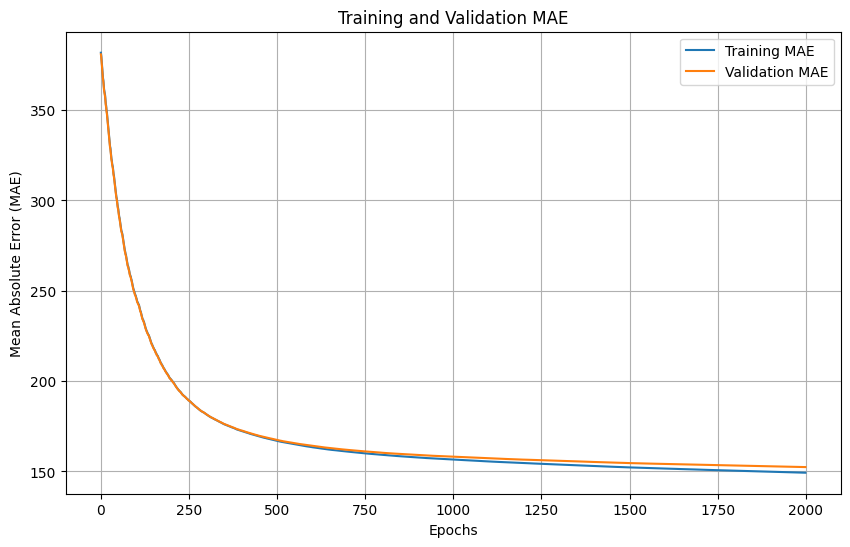

In [84]:
# Ottieni le metriche dal modello
results7 = model7.evals_result()

# Plotta le loss
plt.figure(figsize=(10, 6))
plt.plot(results7['validation_0']['mae'], label='Training MAE')
plt.plot(results7['validation_1']['mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

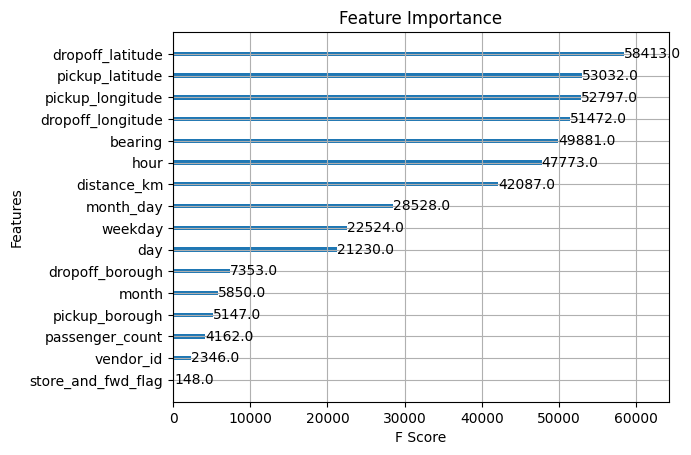

In [85]:
model7.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(10, 8))
plot_importance(model7, max_num_features=30, importance_type="weight", xlabel="F Score")
plt.title("Feature Importance")
plt.show()

## Model Evaluation

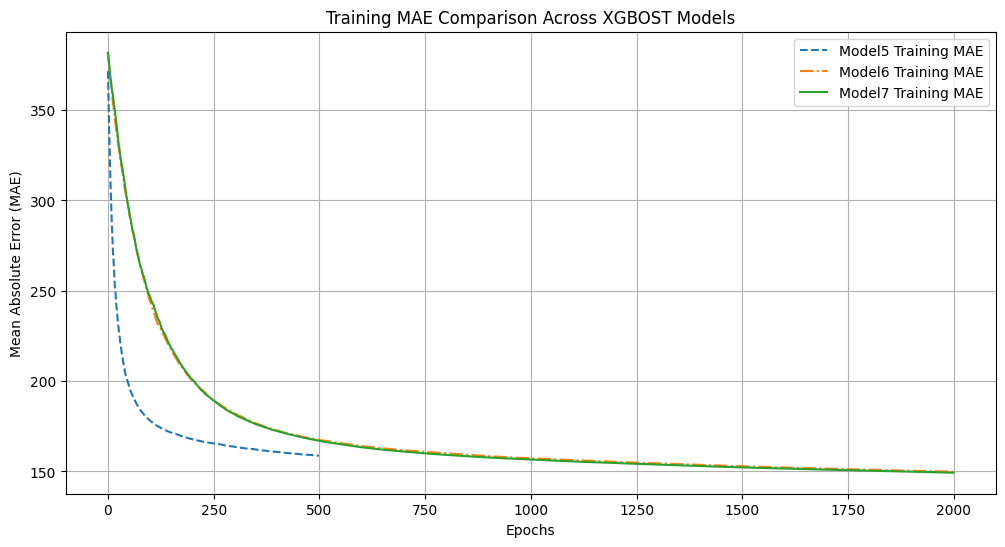

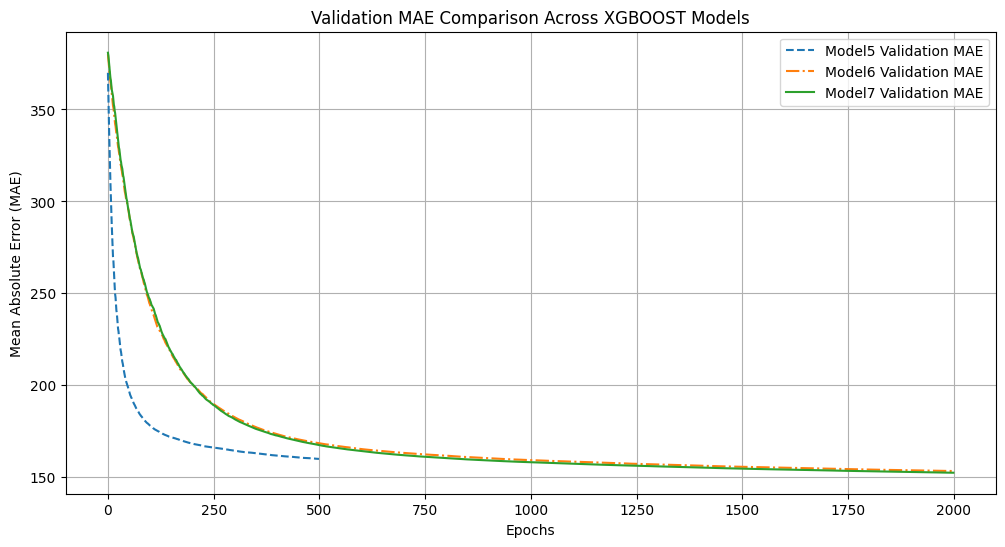

In [86]:
# Plot training MAE for the three models
plt.figure(figsize=(12, 6))
plt.plot(results5['validation_0']['mae'], label='Model5 Training MAE', linestyle='--')
plt.plot(results6['validation_0']['mae'], label='Model6 Training MAE', linestyle='-.')
plt.plot(results7['validation_0']['mae'], label='Model7 Training MAE', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training MAE Comparison Across XGBOST Models')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation MAE for the three models
plt.figure(figsize=(12, 6))
plt.plot(results5['validation_1']['mae'], label='Model5 Validation MAE', linestyle='--')
plt.plot(results6['validation_1']['mae'], label='Model6 Validation MAE', linestyle='-.')
plt.plot(results7['validation_1']['mae'], label='Model7 Validation MAE', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Validation MAE Comparison Across XGBOOST Models')
plt.legend()
plt.grid(True)
plt.show()

Evaluation on the test set

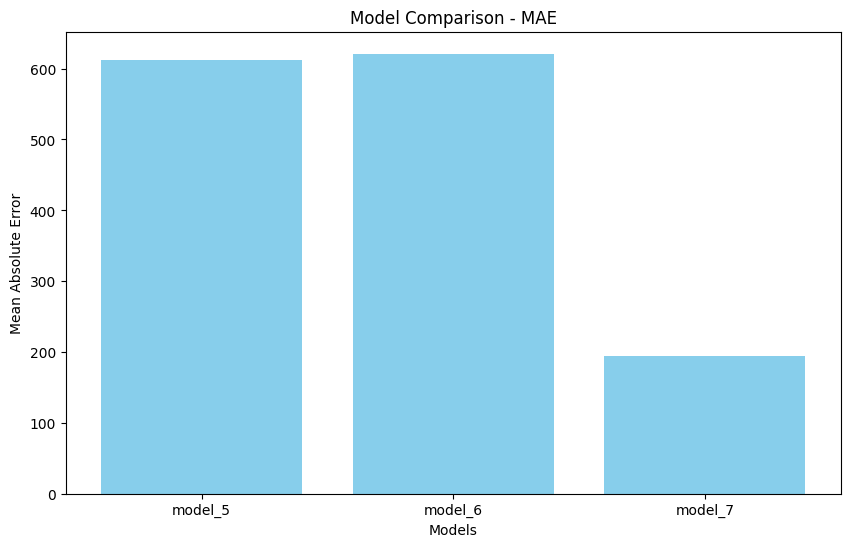

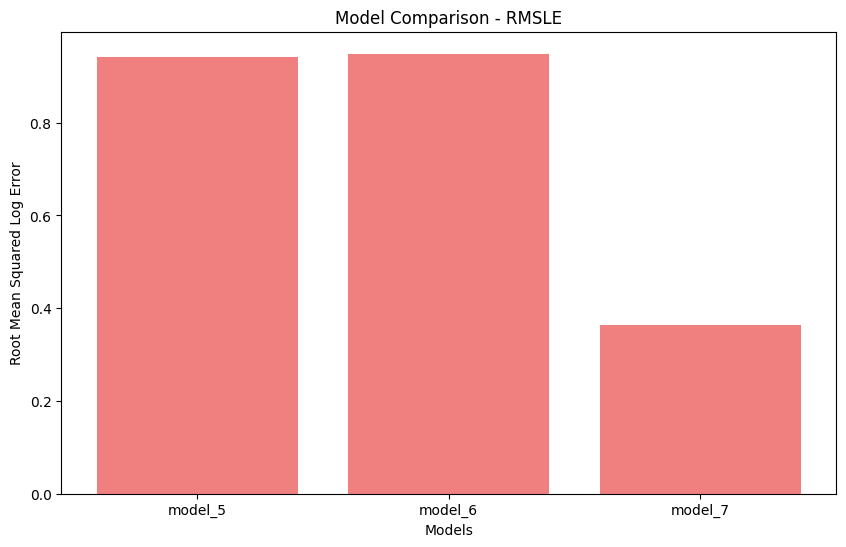

In [94]:
# RMSLE function
def rmsle(y_true, y_pred):
    # Conversion to float and avoiding negative values
    y_true = np.maximum(np.array(y_true, dtype=np.float64), 0)
    y_pred = np.maximum(np.array(y_pred, dtype=np.float64), 0)
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Ensure feature alignment between training and test sets
def align_features(model, X):
    model_features = model.get_booster().feature_names
    X_aligned = pd.DataFrame(X, columns=model_features).reindex(columns=model_features, fill_value=0)
    return X_aligned

# Function to calculate metrics
def evaluate_model(model, X_test, y_test):
    X_test_aligned = align_features(model, X_test)
    predictions = model.predict(X_test_aligned)
    mae = mean_absolute_error(y_test, predictions)
    rmsle_value = rmsle(y_test, predictions)
    return mae, rmsle_value

# Evaluate each model
metrics = {}
metrics['model_5'] = evaluate_model(model5, X_test, y_test)
metrics['model_6'] = evaluate_model(model6, X_test, y_test)
metrics['model_7'] = evaluate_model(model7, X_test, y_test)

# Prepare data for plotting
models = list(metrics.keys())
mae_values = [metrics[m][0] for m in models]
rmsle_values = [metrics[m][1] for m in models]

# Plot MAE
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color='skyblue')
plt.title('Model Comparison - MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Models')
plt.show()

# Plot RMSLE
plt.figure(figsize=(10, 6))
plt.bar(models, rmsle_values, color='lightcoral')
plt.title('Model Comparison - RMSLE')
plt.ylabel('Root Mean Squared Log Error')
plt.xlabel('Models')
plt.show()


The results on the test set show a clear distinction in performance among the models. Model 7 significantly outperforms both Model 5 and Model 6, achieving the lowest MAE and RMSLE. This indicates that Model 7 has better accuracy and handles proportional errors more effectively compared to the other two models.

Both Model 5 and Model 6 exhibit similar performance, with high MAE and RMSLE values, suggesting they struggle to generalize well on the test set. The superior performance of Model 7 is given to the ability to handle non-scaled data and categorical features effectively when label encoding is used.